In [35]:
# read in wrfout files

import glob
import wrf
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt

site_latitude  = 36.6050
site_longitude = -97.485

wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/l1_0805m/'

In [29]:
def get_pblh(domain): 
    
    wrf_file_list = glob.glob(wrf_path+'wrfout_d0'+str(domain)+'*')

    for ind, file in enumerate(wrf_file_list):

        wrf_single = Dataset(file, 'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

        pblh = wrf.getvar(wrf_single, 'PBLH')
        pblh_1pt = pblh[site_loc_ij.values[1], site_loc_ij.values[0]]

        if ind == 0: 
            pblh_1pt_all = pblh_1pt
        else: 
            pblh_1pt_all = xr.concat([pblh_1pt, pblh_1pt_all], dim='Time')

    return pblh_1pt_all.sortby('Time')

In [41]:
pblh_d02 = get_pblh(2)
pblh_d03 = get_pblh(2)
pblh_d04 = get_pblh(4)

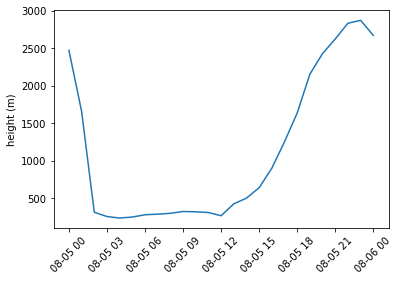

In [46]:
plt.plot(pblh_d02['Time'], pblh_d02)
# plt.plot(pblh_d03['Time'], pblh_d03)
# plt.plot(pblh_d04['Time'], pblh_d04)
plt.tick_params(axis='x', rotation=45)
plt.ylabel('height (m)')
plt.show()

In [43]:
pblh_d04

<xarray.DataArray 'PBLH' (Time: 10)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
    XLONG    float32 -97.48
    XLAT     float32 36.6
    XTIME    (Time) float32 1.62e+03 1.68e+03 1.74e+03 ... 2.1e+03 2.16e+03
  * Time     (Time) datetime64[ns] 2018-08-05T15:00:00 ... 2018-08-06
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  PBL HEIGHT
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [9]:
pblh = wrf.getvar(wrf_single, 'PBLH')

In [12]:
site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

In [16]:
pblh_1pt = pblh[site_loc_ij.values[1], site_loc_ij.values[0]]

In [17]:
pblh_1pt

    if ind == 0: 
        ds_all = ds
    else: 
        ds_all = xr.concat([ds, ds_all], dim='Time')

<xarray.DataArray 'PBLH' ()>
array(300.84473, dtype=float32)
Coordinates:
    XLONG    float32 -97.49
    XLAT     float32 36.59
    XTIME    float32 1.2e+03
    Time     datetime64[ns] 2018-08-05T08:00:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  PBL HEIGHT
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [6]:
for ind, file in enumerate(wrf_file_list[0]):
    
    print(file)

    wrf_single = Dataset(file, 'r')

    pblh = wrf.getvar(wrf_single, 'PBLH')

/


OSError: [Errno -51] NetCDF: Unknown file format: b'/'

In [1]:
# read in wrf auxout & lasso files
# compare large scale forcing

# perform area average on wrf 3-km outputs
# in order to match lasso 16-km outputs

# time-height plots

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import math
import seaborn as sns
import itertools

# c1 site location
site_latitude  = 36.6050
site_longitude = -97.485

wrf_date, wrf_setting = ['0805', '0901'], ['m', 'e']
wrf_dirs = list(itertools.product(wrf_date, wrf_setting))

# interpolate wrf variables to this height
# also a specified height in lasso data
target_height_agl = 80

# only select data up to this altitude
threshold_height = 2000

lasso_metadf = pd.read_csv('lasso-metadata.csv')

def get_lasso_forcing_ds(file, year, month, date):

    ds = xr.open_dataset(file)

    for ind, val in enumerate(ds['Times']): 

        ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
        ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')

    ds = ds.assign_coords({'Time': ds.Times})

    # select 24 hours of data
    select = ds.sel(Time=slice(datetime.datetime(year, month, date), datetime.datetime(year, month, date+1)))

    select = select.assign_coords({'force_layers': select['Z_LS'][0].values})

    return select

def plot_timeheight_wrflasso_uvtend(wrf_var, lasso_var, wrf_title, lasso_title, vars_txt, plt_txt): 

    wrf_da, lasso_da = wrf_ds_below2km[wrf_var], lasso_sounding_ds_below2km[lasso_var]
    v_max = np.max([wrf_da.max(), lasso_da.max()])
    v_min = np.min([wrf_da.min(), lasso_da.min()])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    
    p1 = wrf_da.plot(x='Time', y='Height', vmin=v_min, vmax=v_max, ax=ax1)
    ax1.set_ylabel('Height agl (m)')
    ax1.set_title(wrf_title)
    
    p2 = lasso_da.plot(x='Time', y='Height', vmin=v_min, vmax=v_max, ax=ax2)
    ax2.set_ylabel('Height agl (m)')
    ax2.set_title(lasso_title)

    plt.tight_layout()
    plt.savefig('plots_02c/'+plt_txt+'_th_'+vars_txt+'.pdf')
    plt.show()
    
def plot_timeheight_wrflasso_tempadv(wrf_ds, lasso_ds, wrf_title, lasso_title, plt_txt):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    p1 = wrf_ds['Temp advection [K s-1]'].plot(x='Time', y='Height', ax=ax1)

    ax1.set_ylabel('Height agl (m)')
    ax1.set_title('WRF temperature advection; '+wrf_title)

    p2 = lasso_ds['TH_ADV'].plot(x='Time', y='force_layers', ax=ax2)

    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylabel('Height agl (m)')
    ax2.set_title('LASSO temperature advection; '+lasso_title)

    plt.tight_layout()
    plt.savefig('plots_02c/'+plt_txt+'_th_tempadv.pdf')
    plt.show()

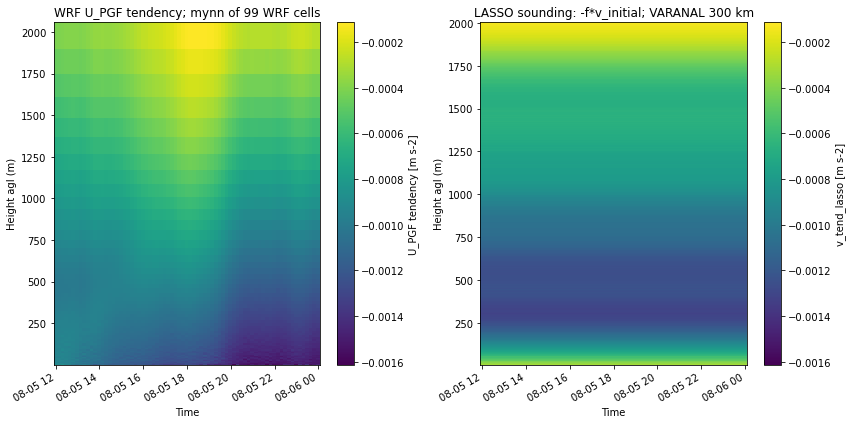

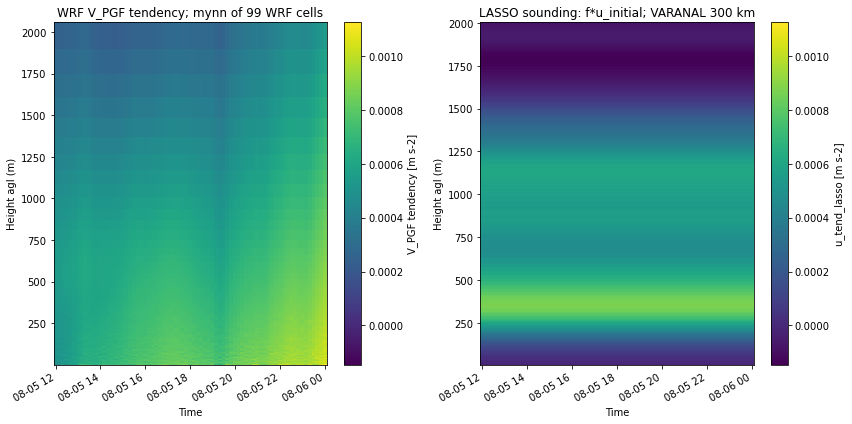

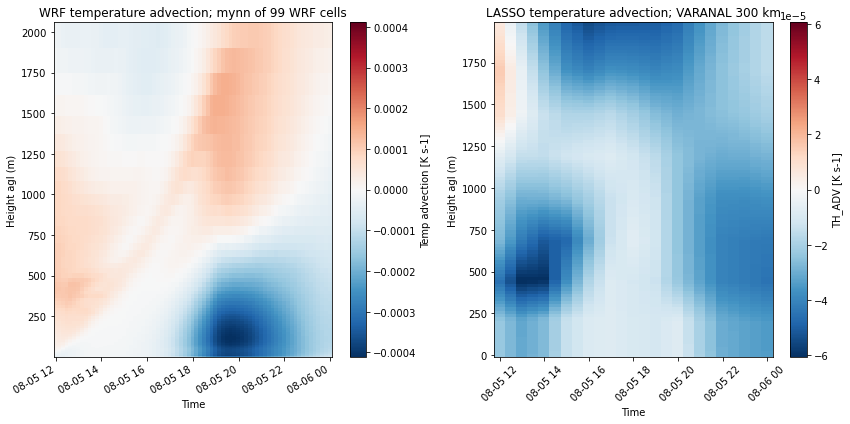

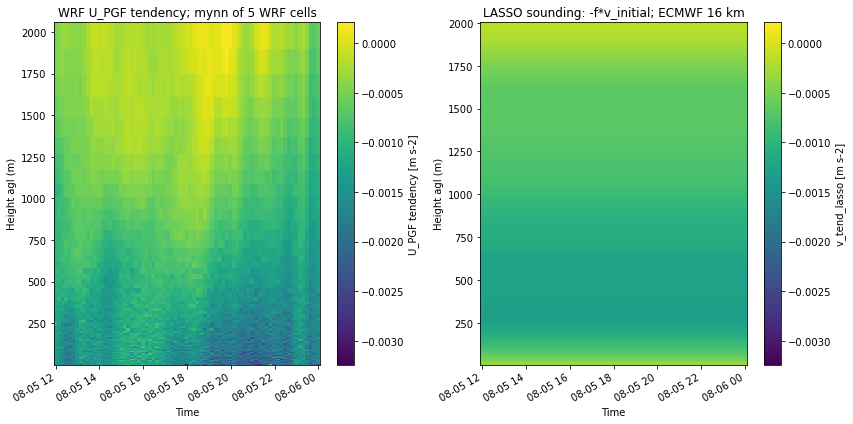

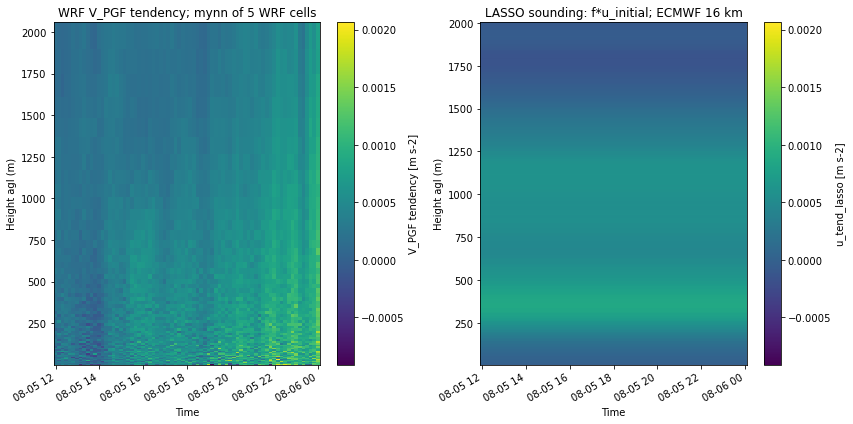

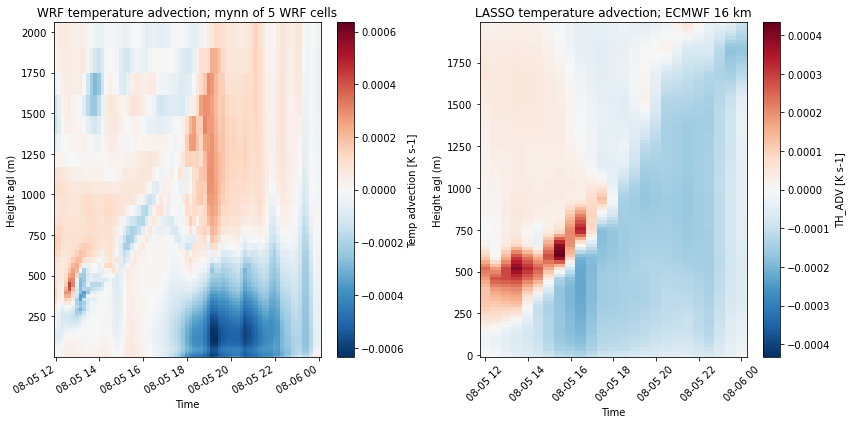

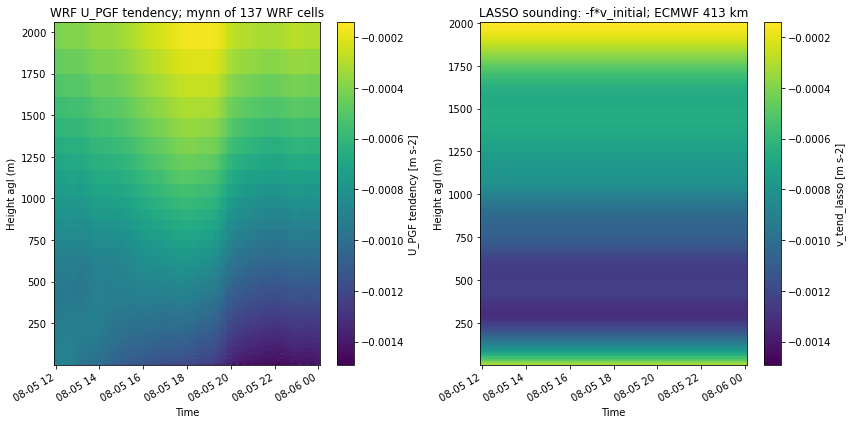

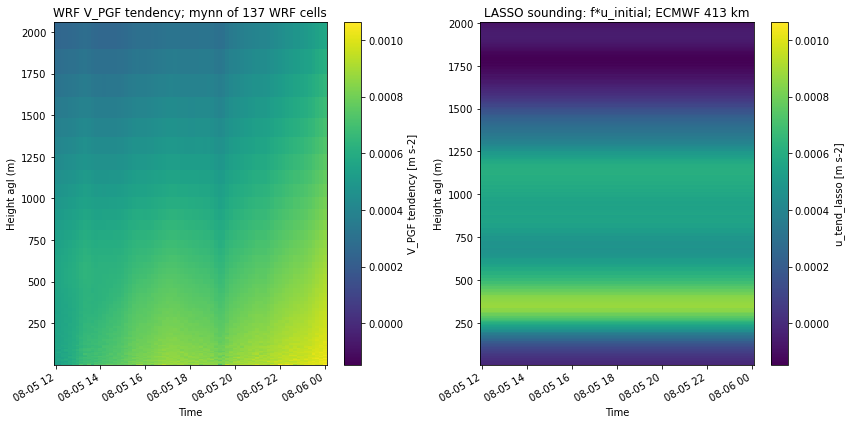

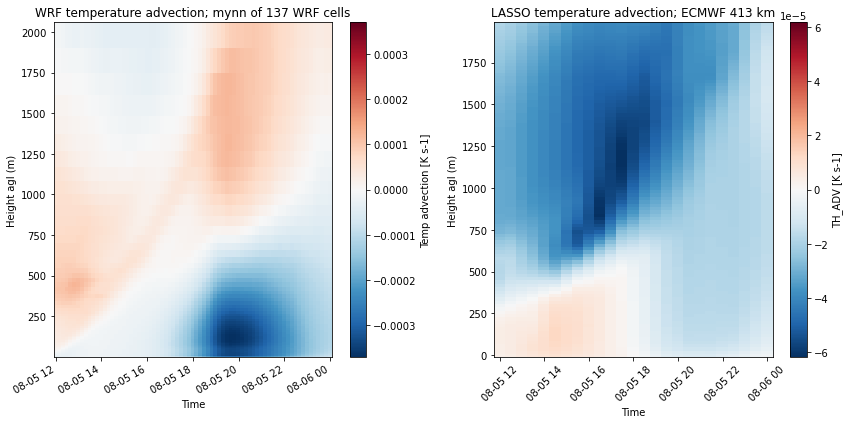

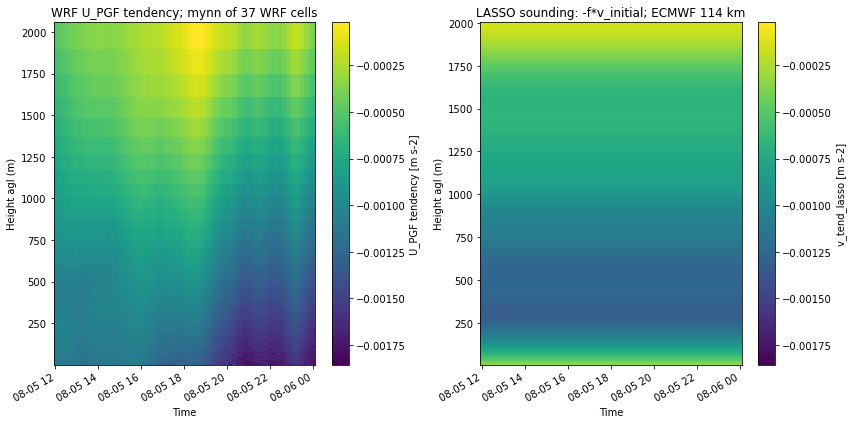

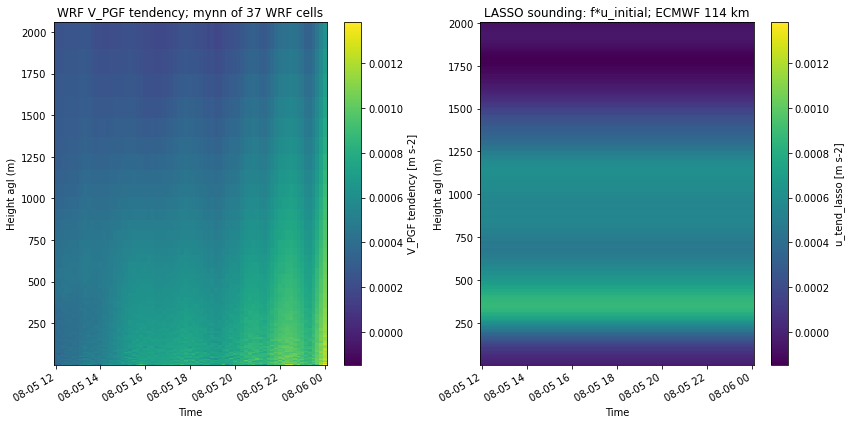

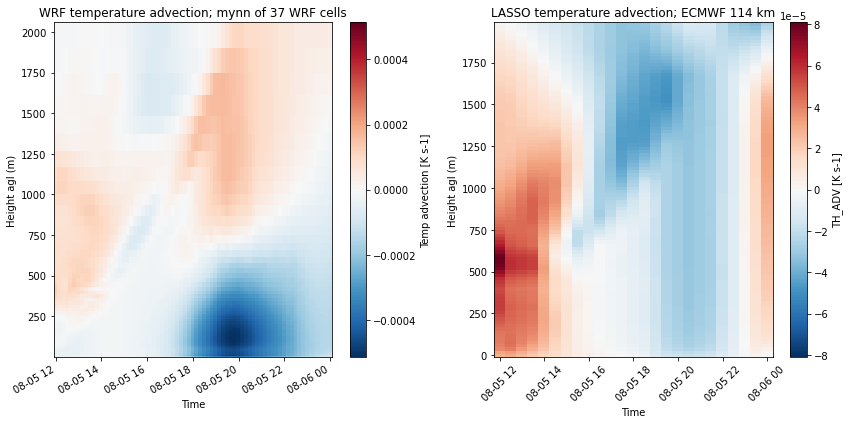

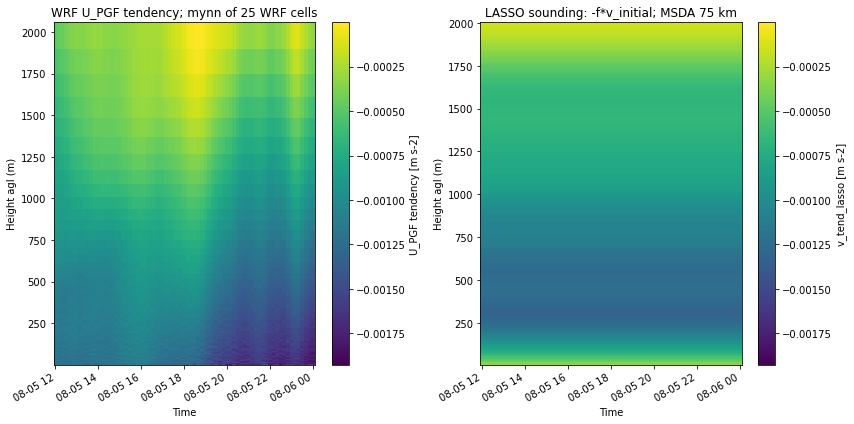

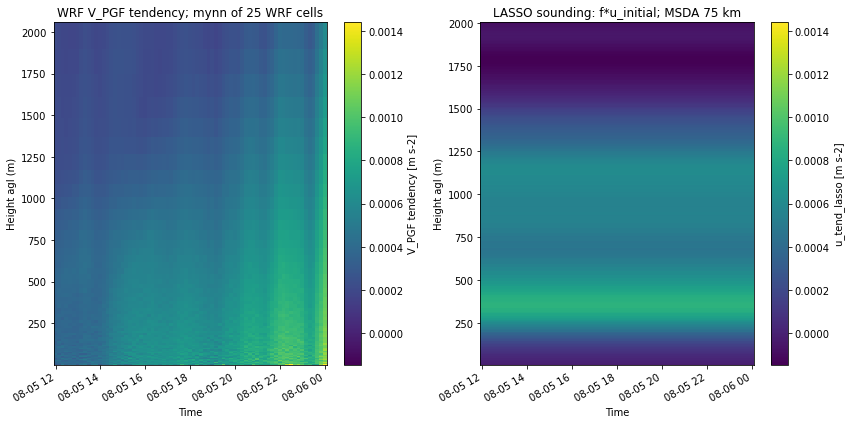

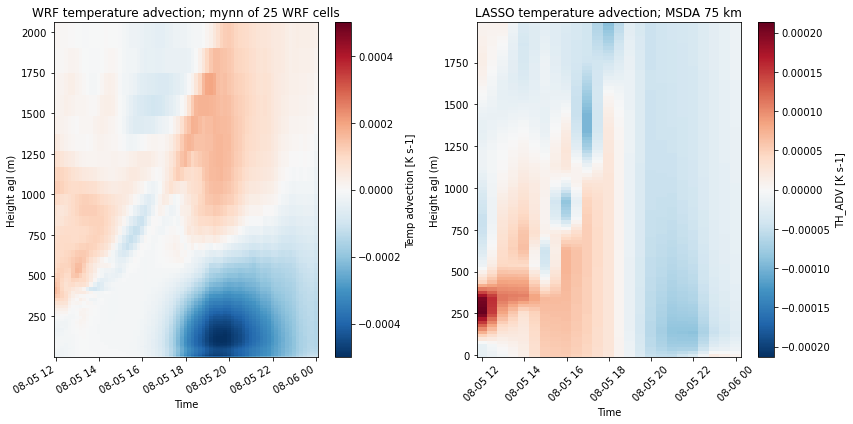

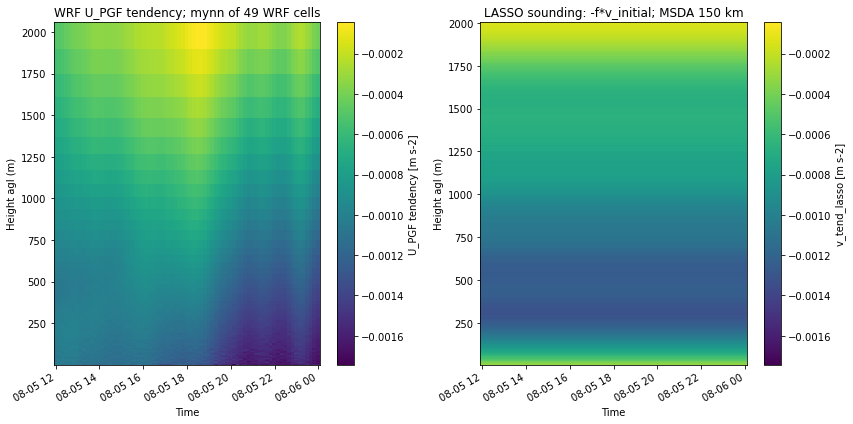

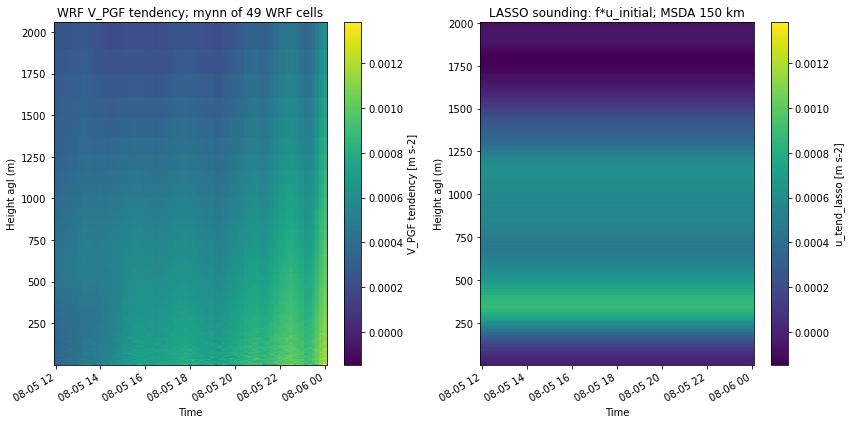

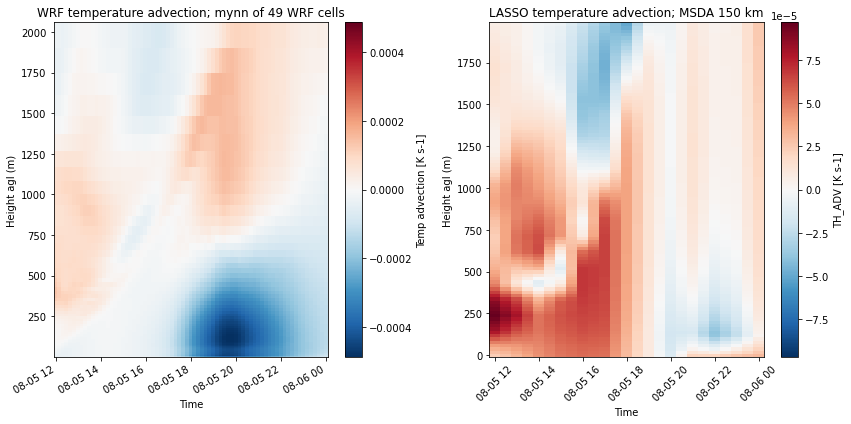

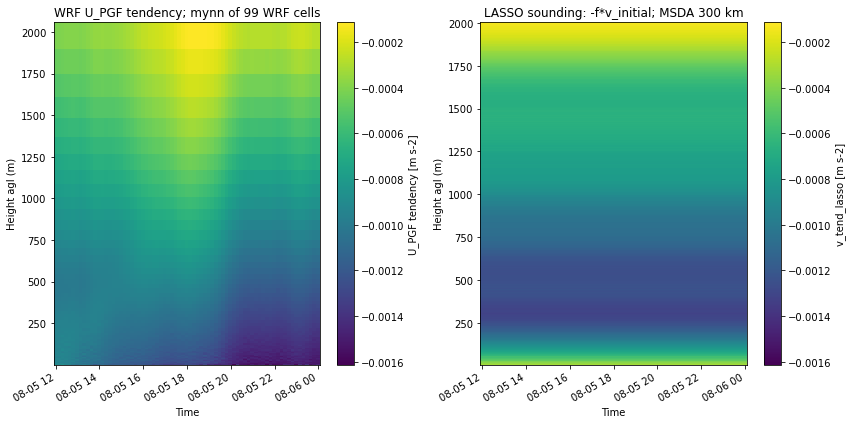

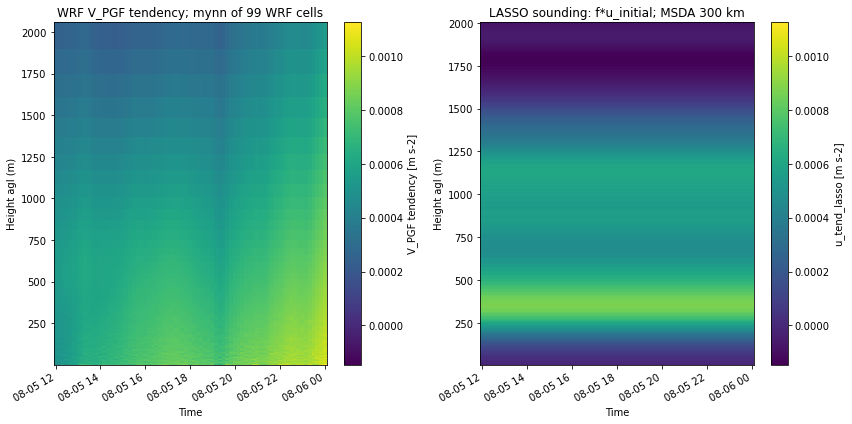

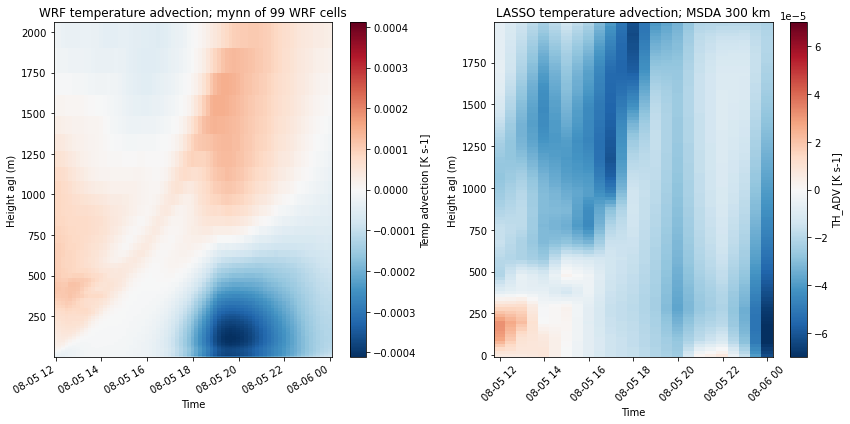

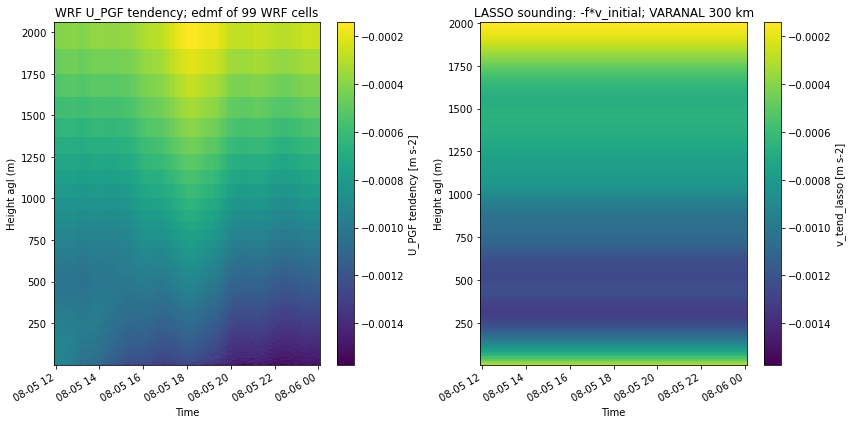

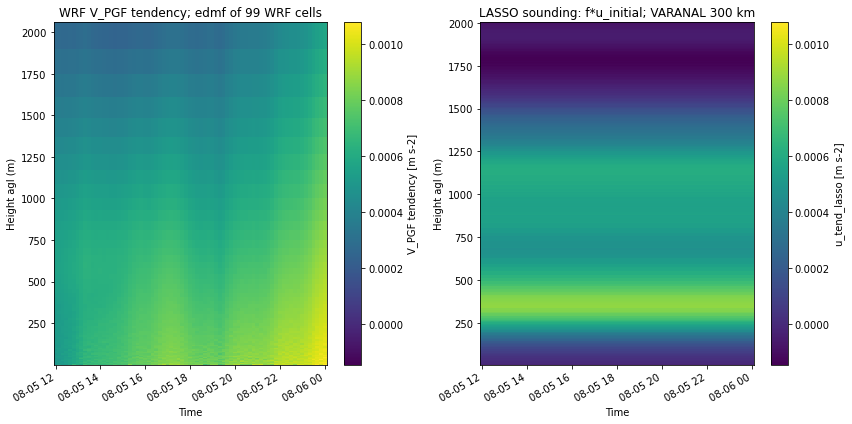

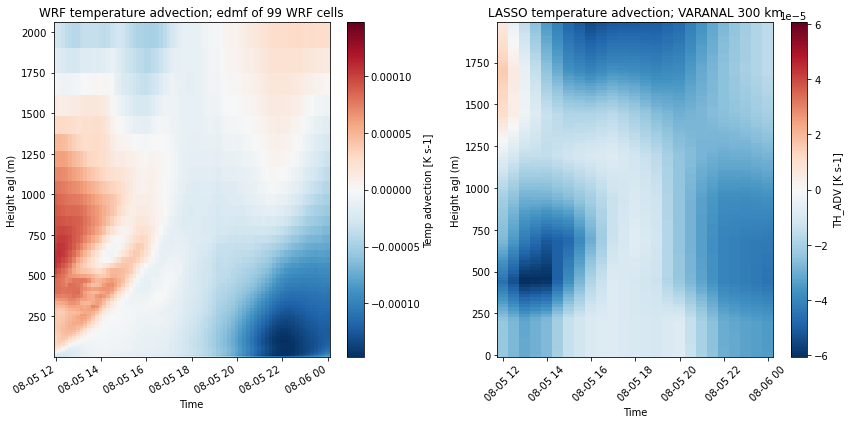

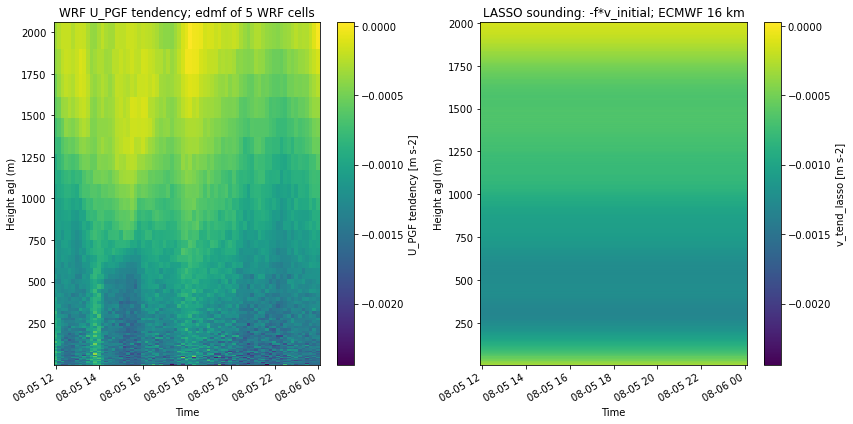

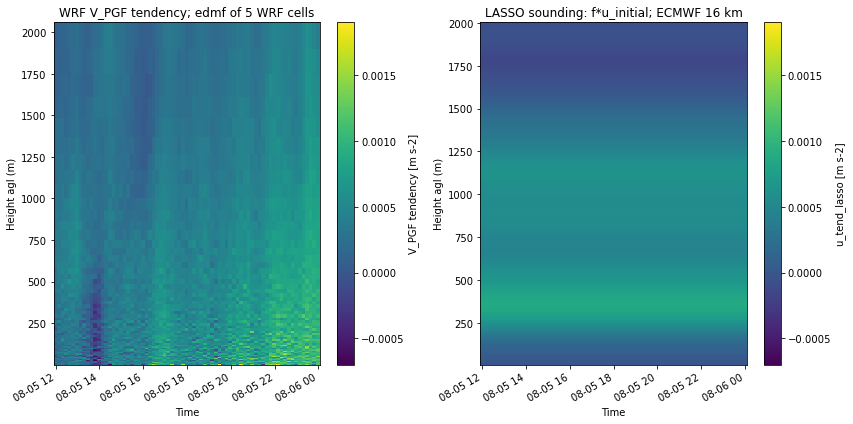

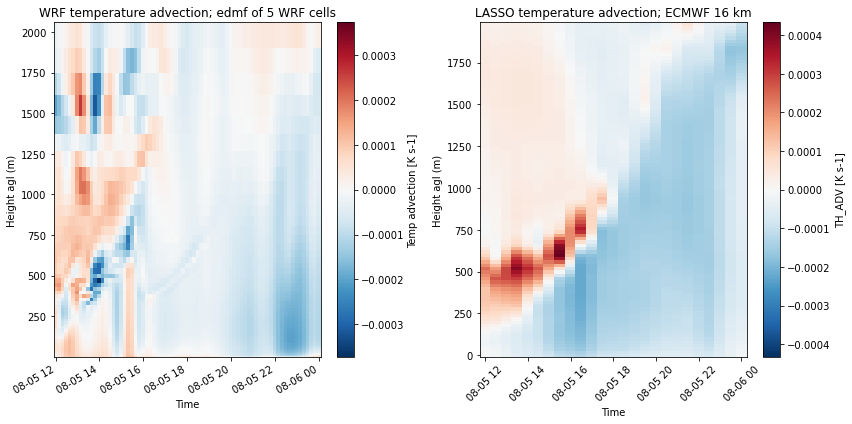

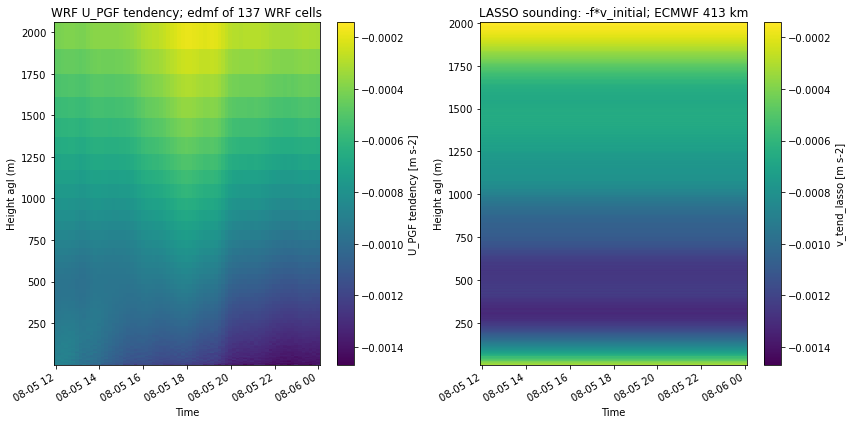

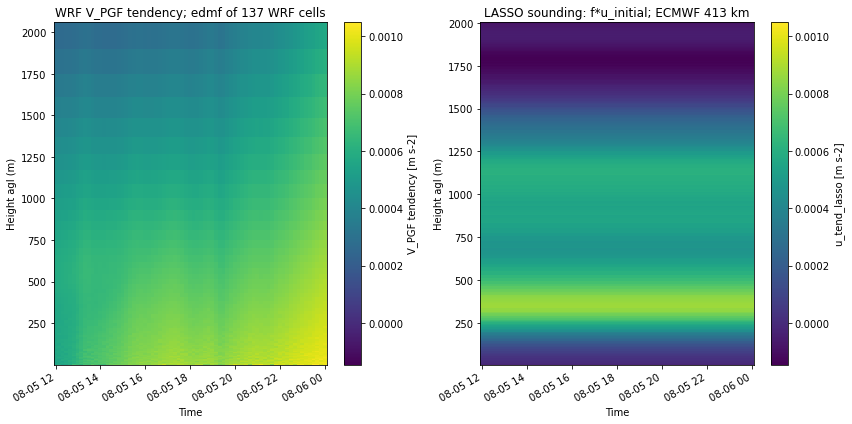

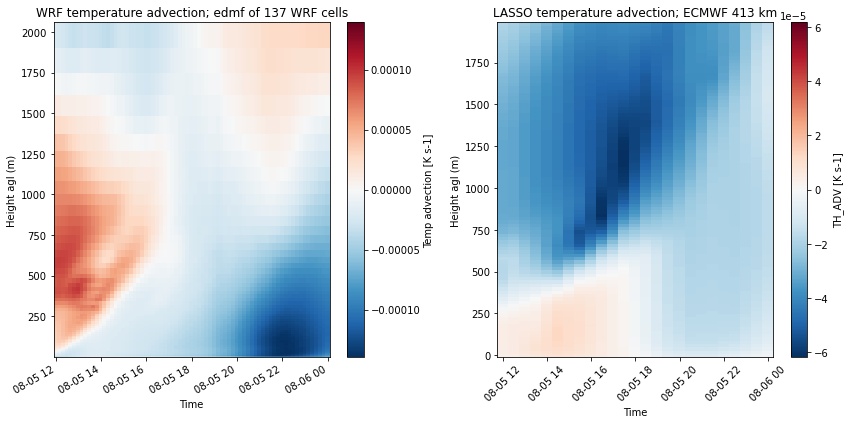

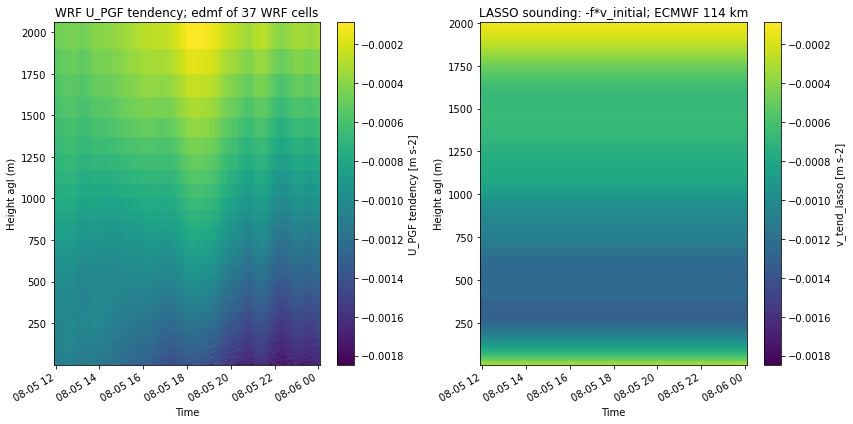

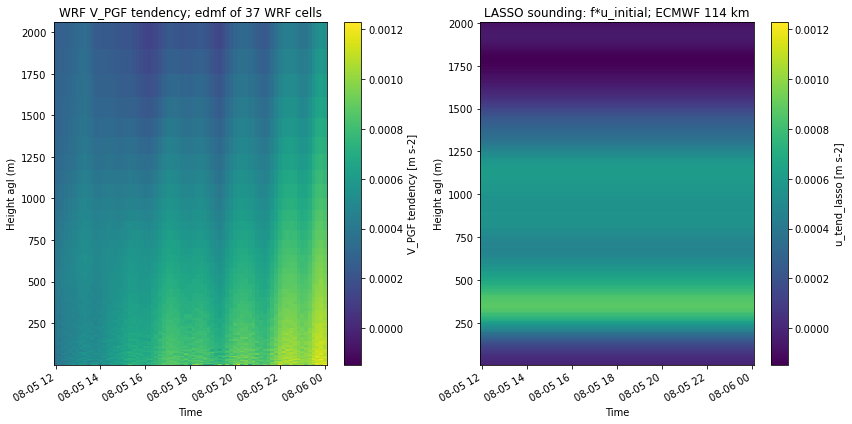

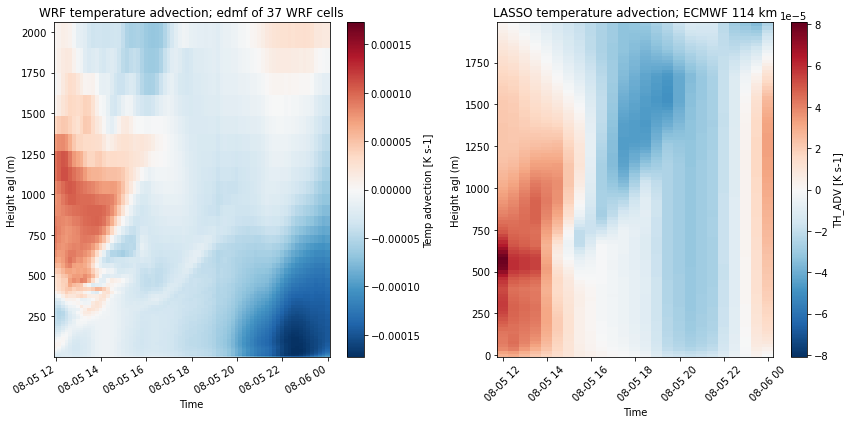

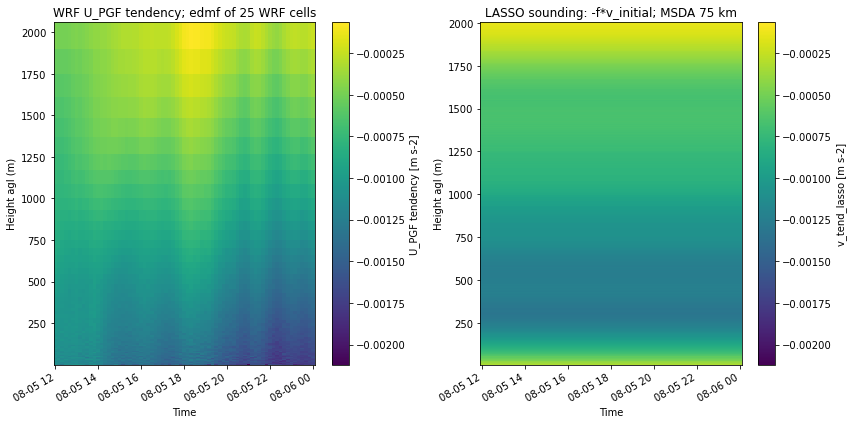

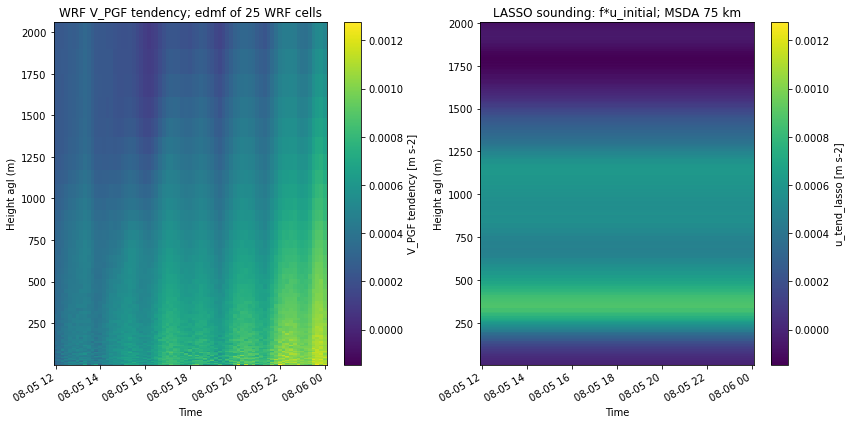

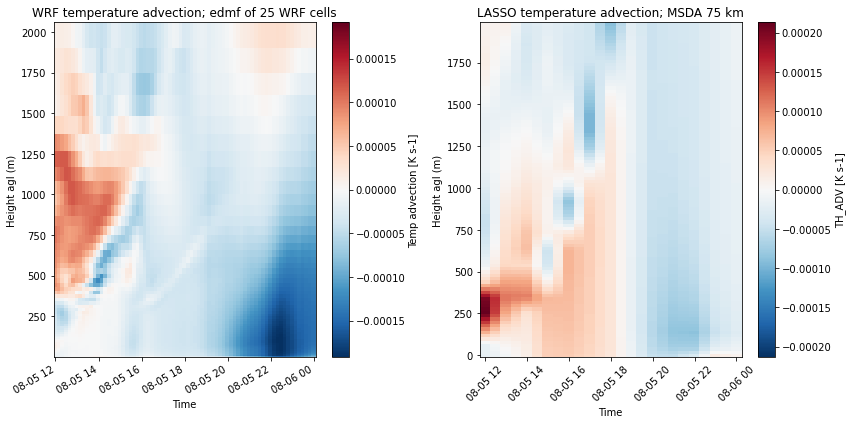

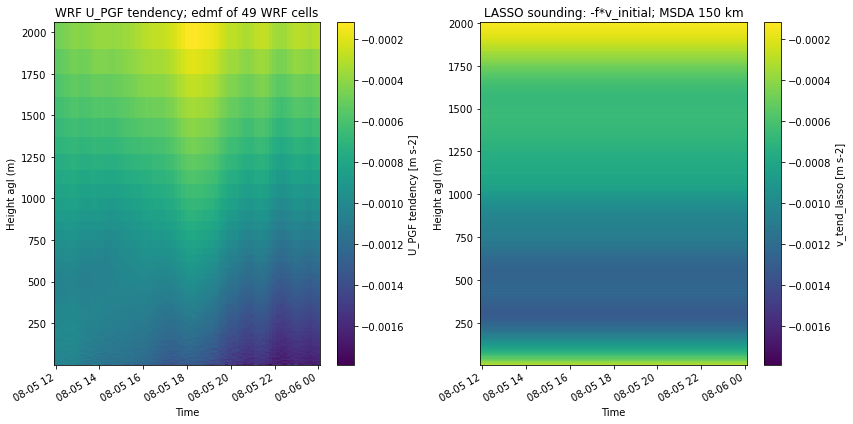

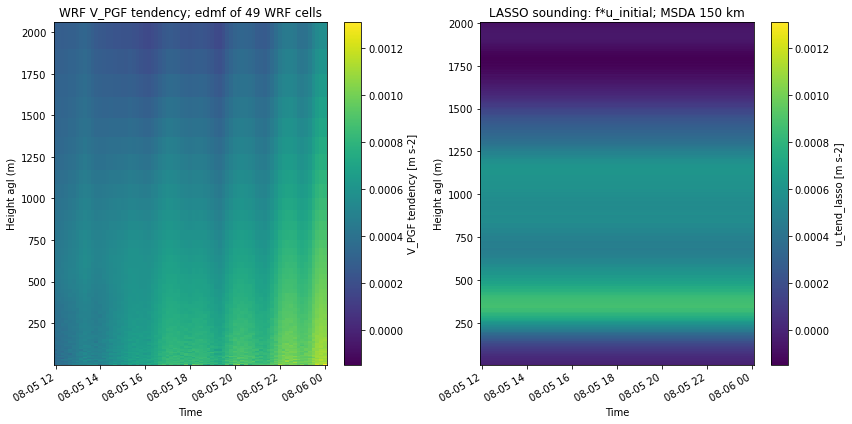

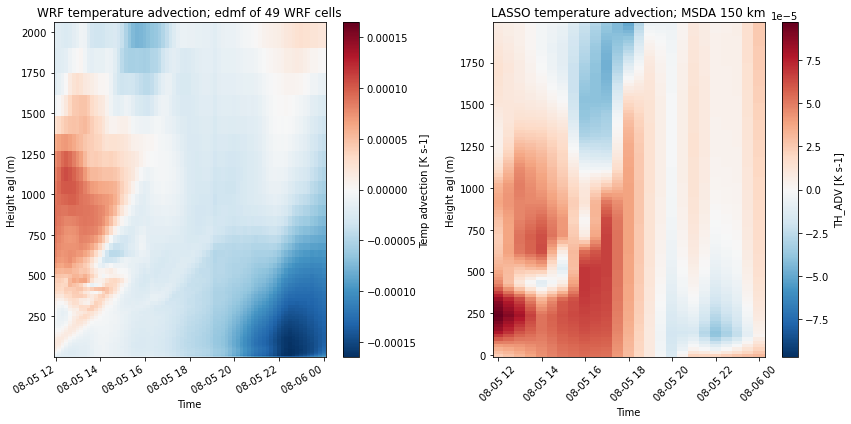

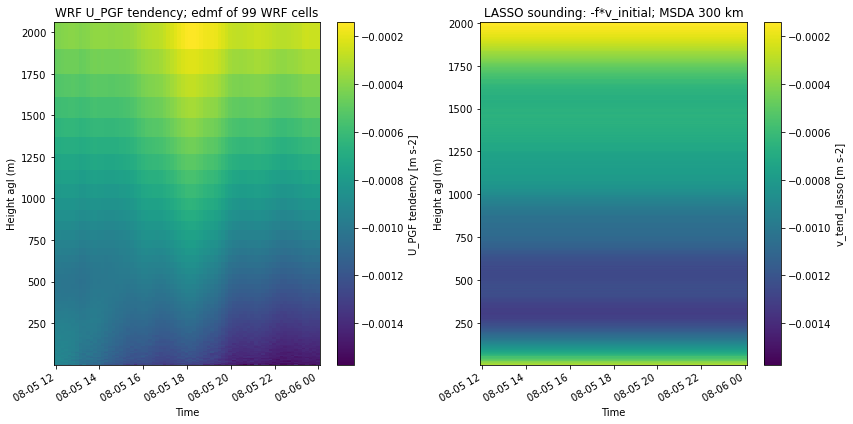

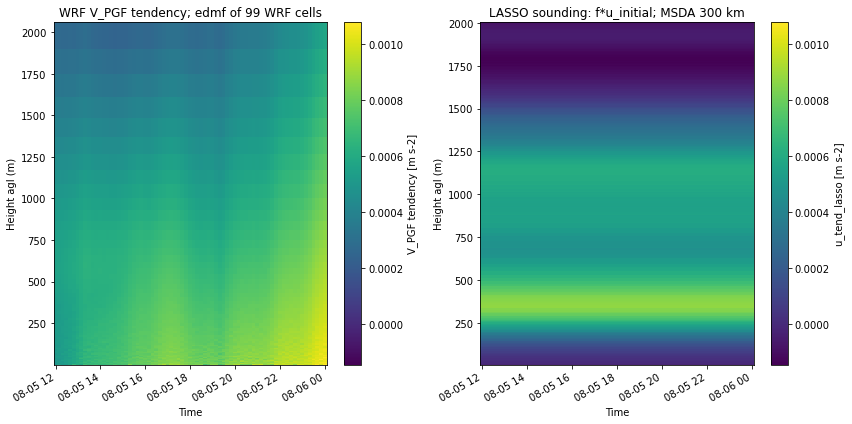

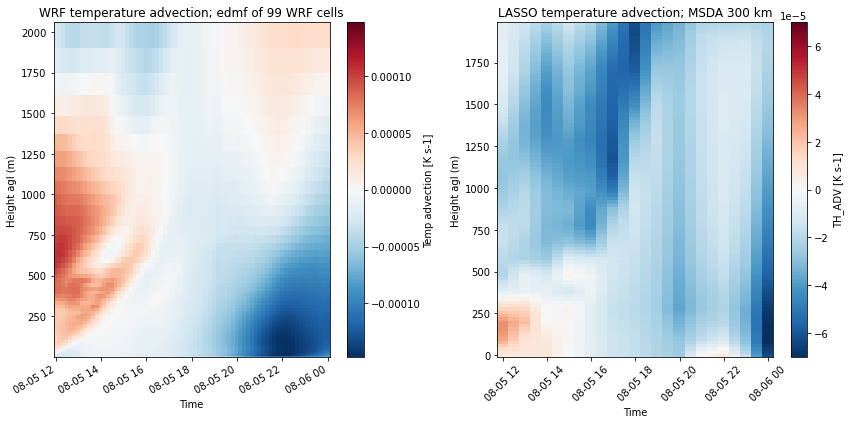

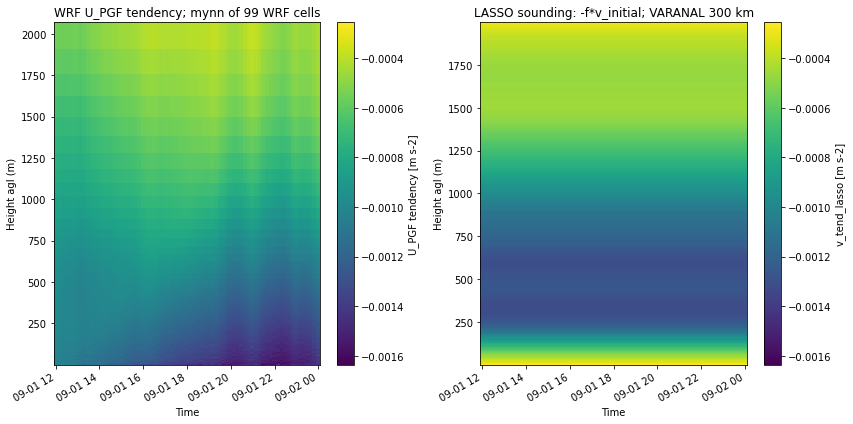

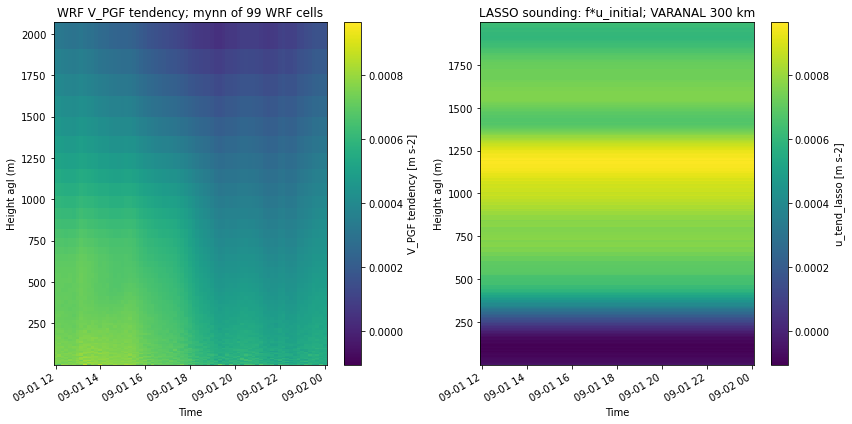

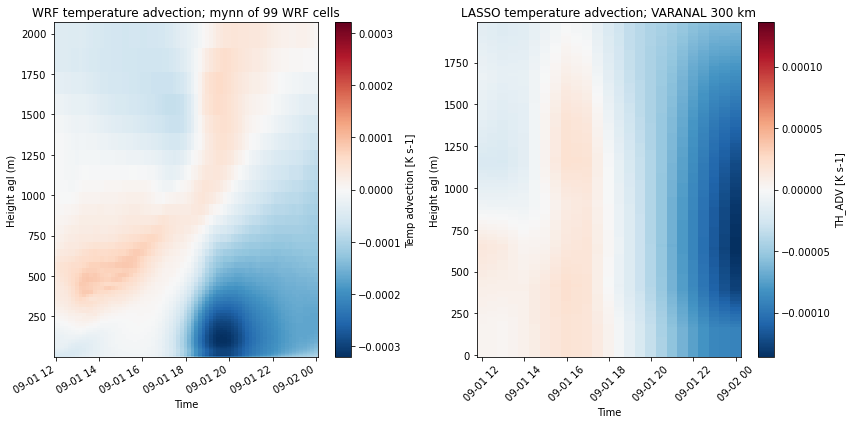

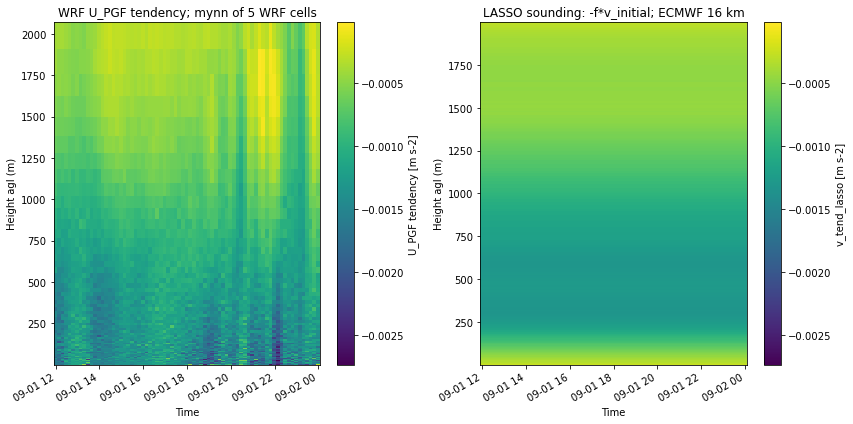

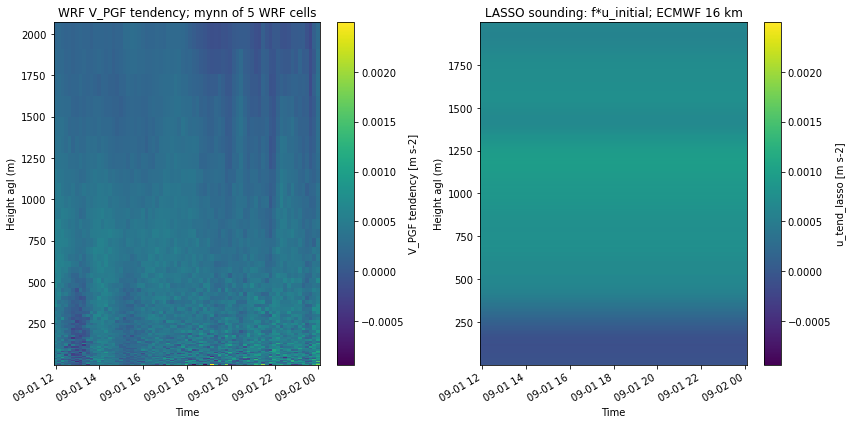

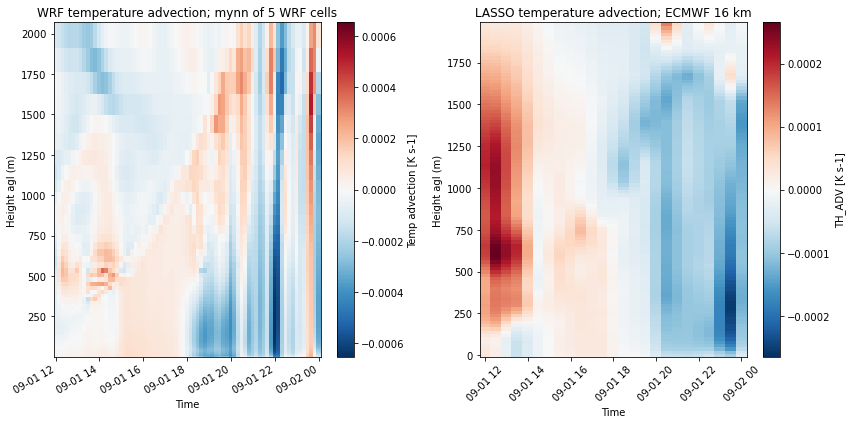

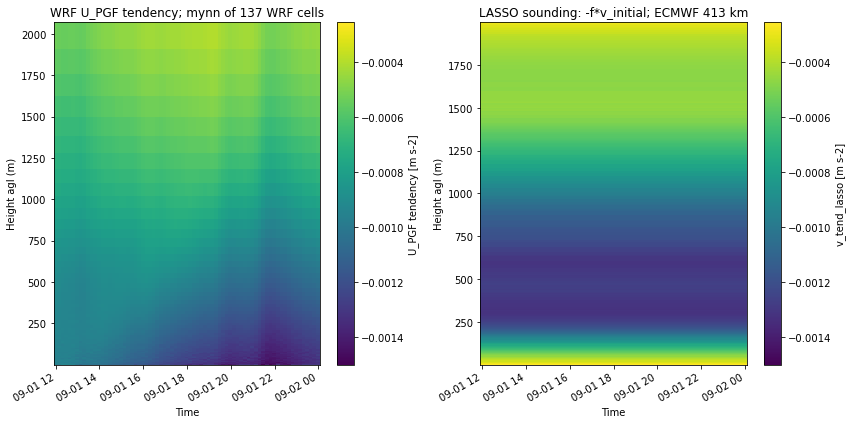

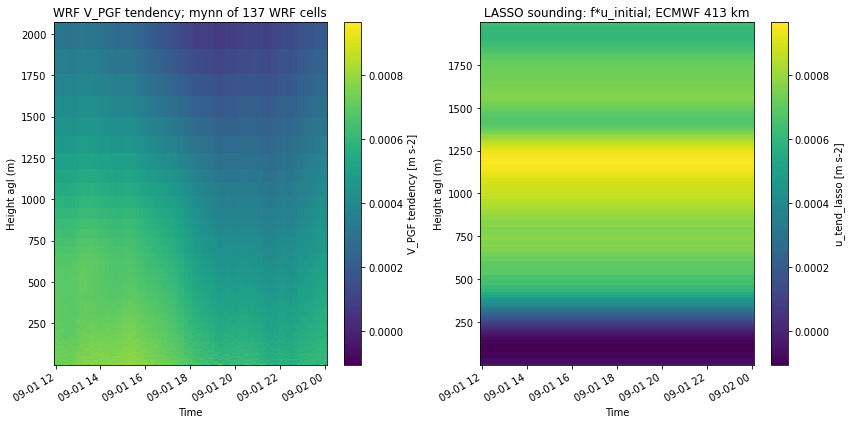

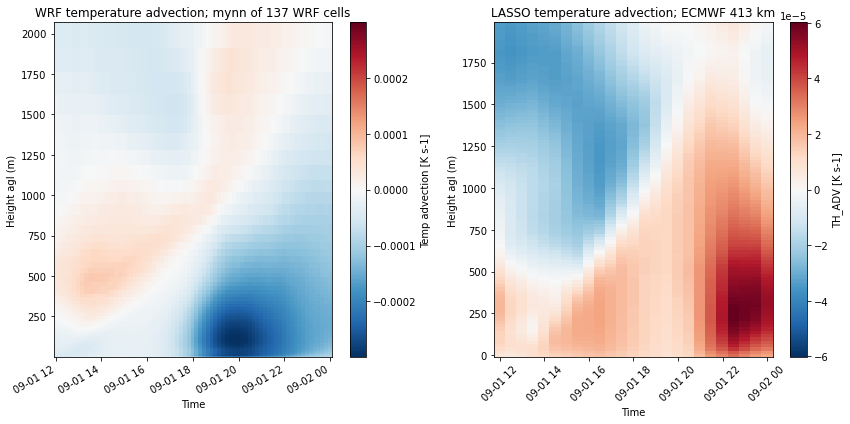

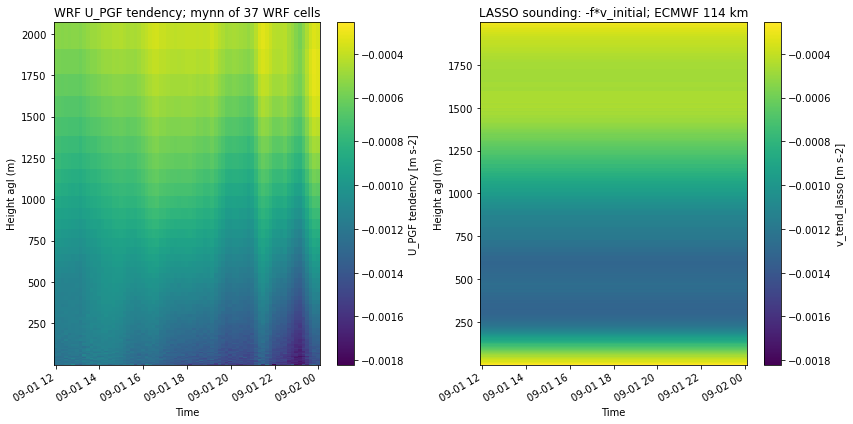

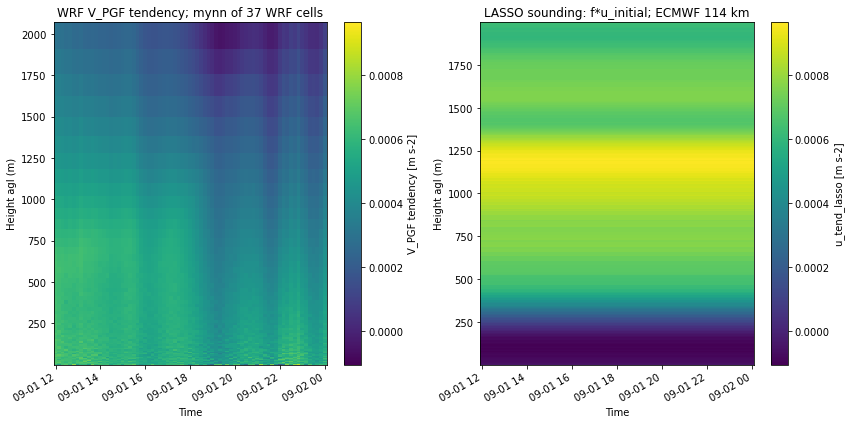

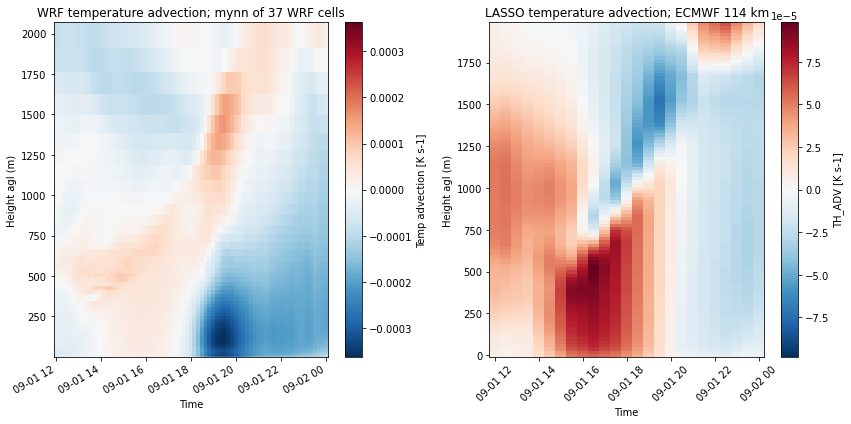

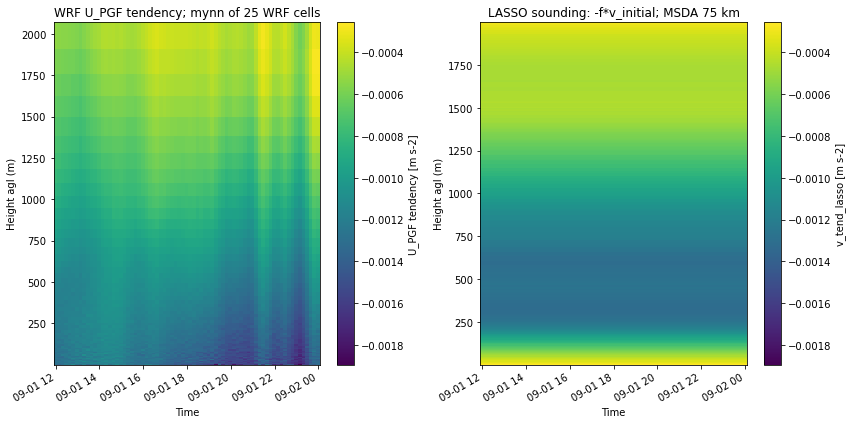

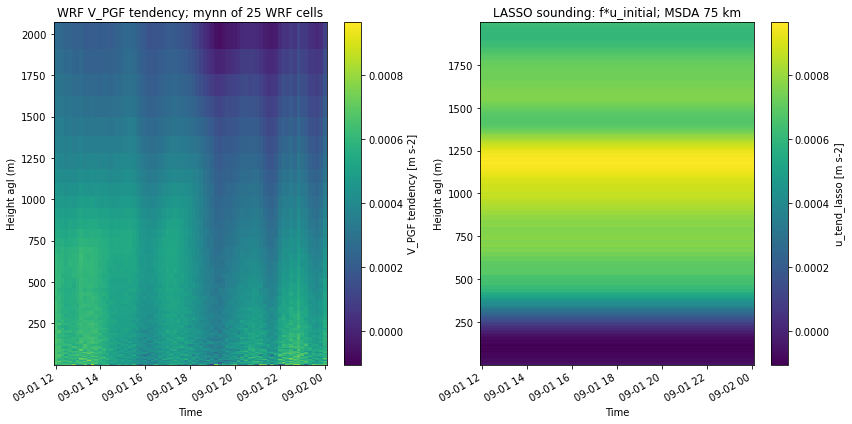

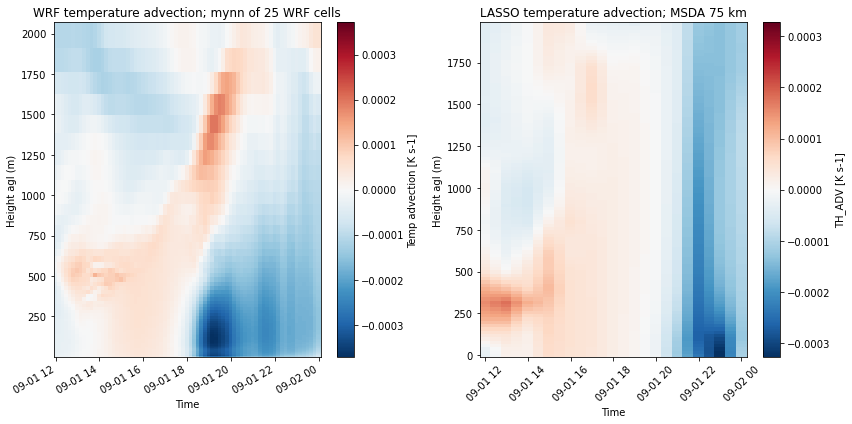

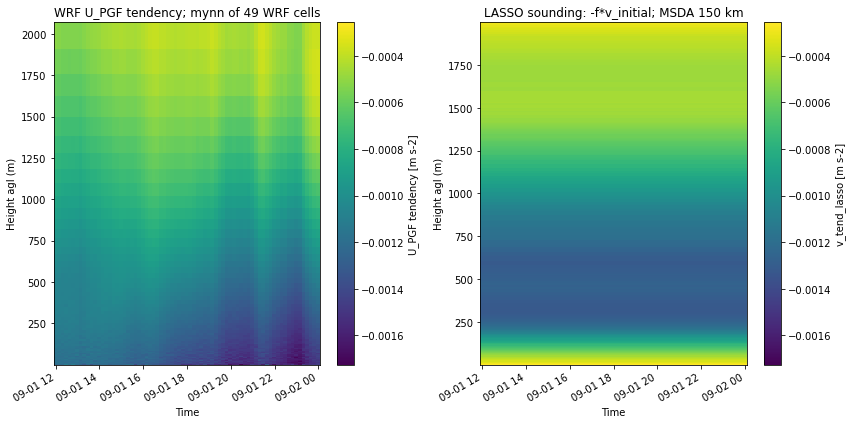

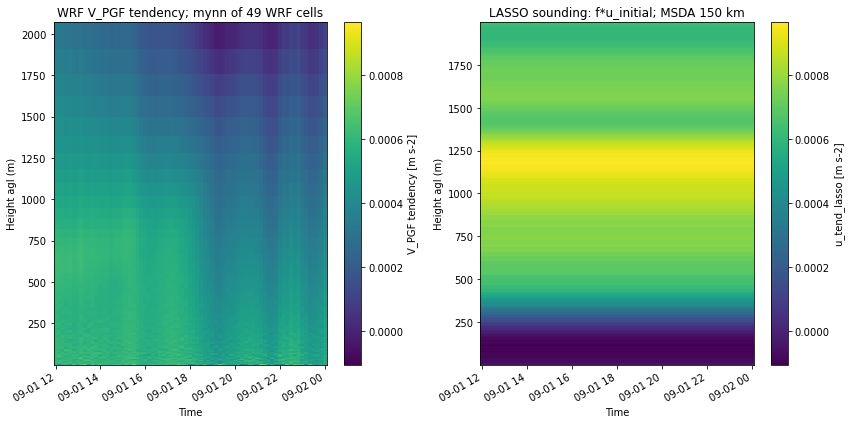

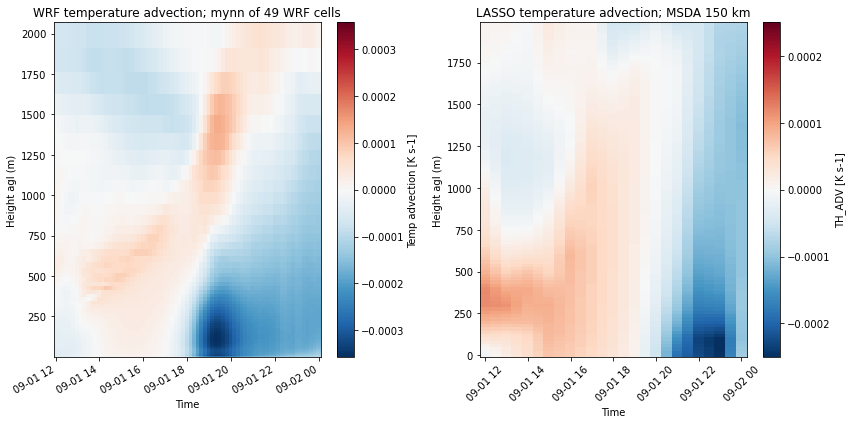

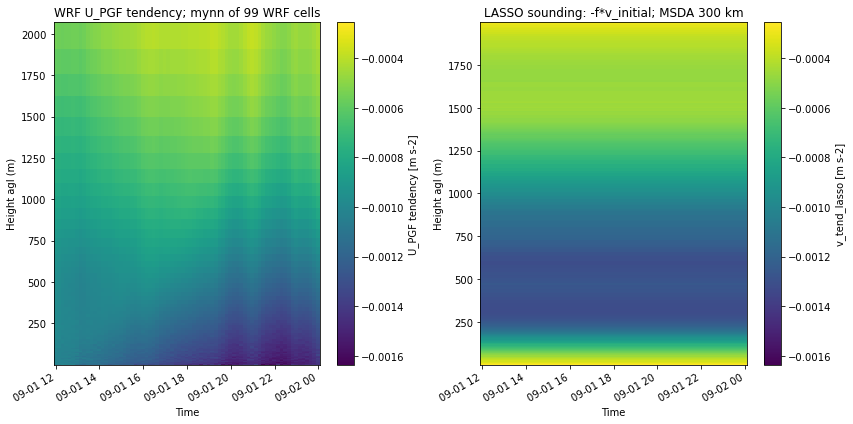

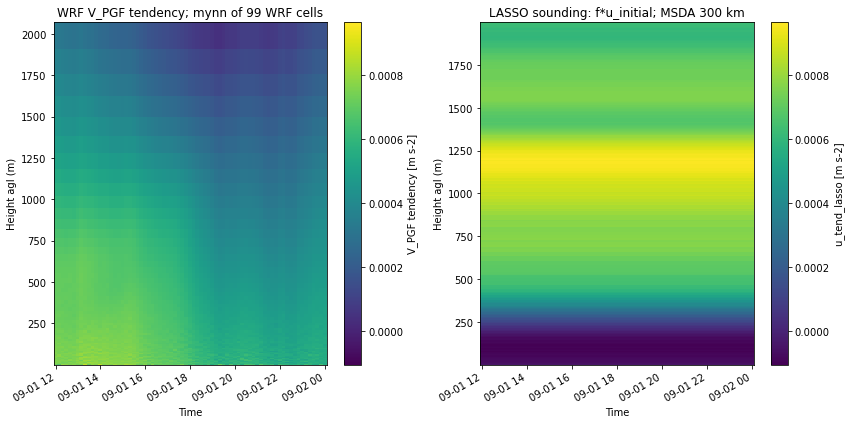

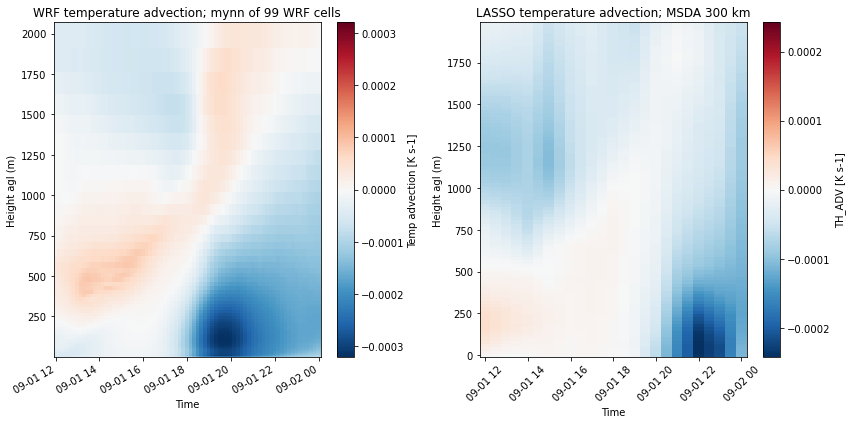

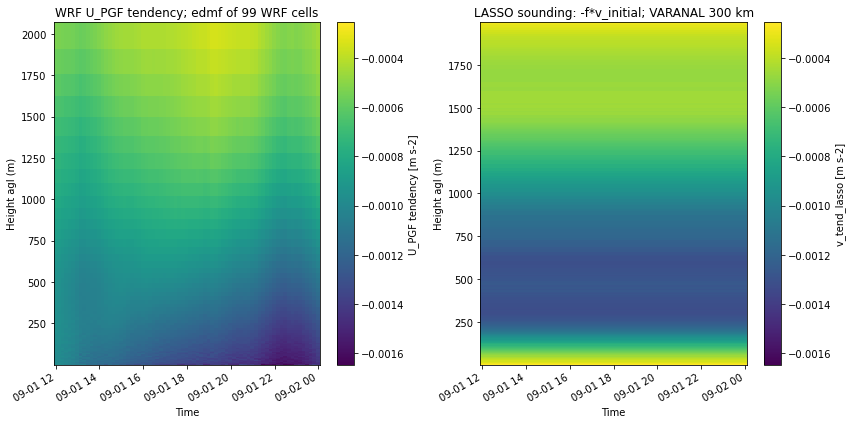

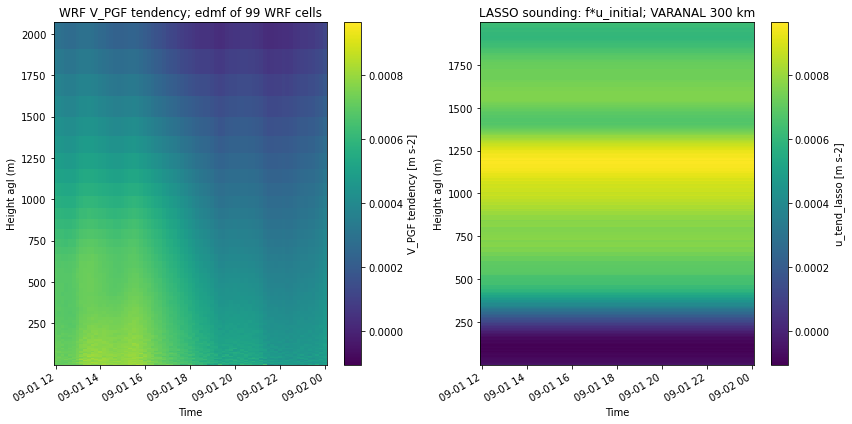

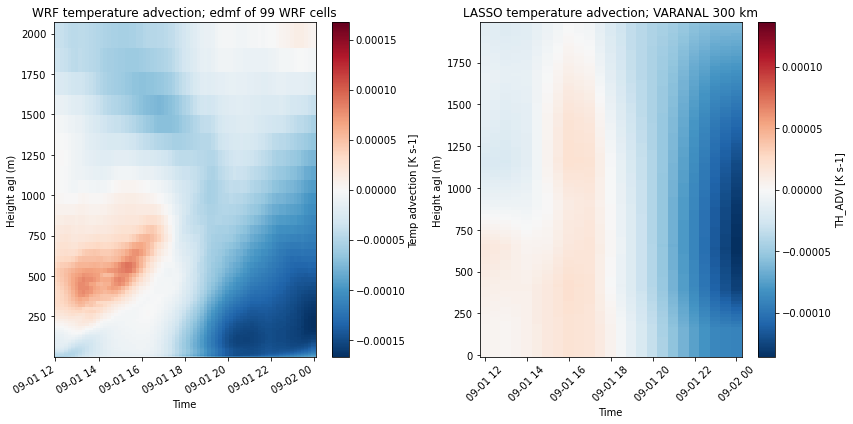

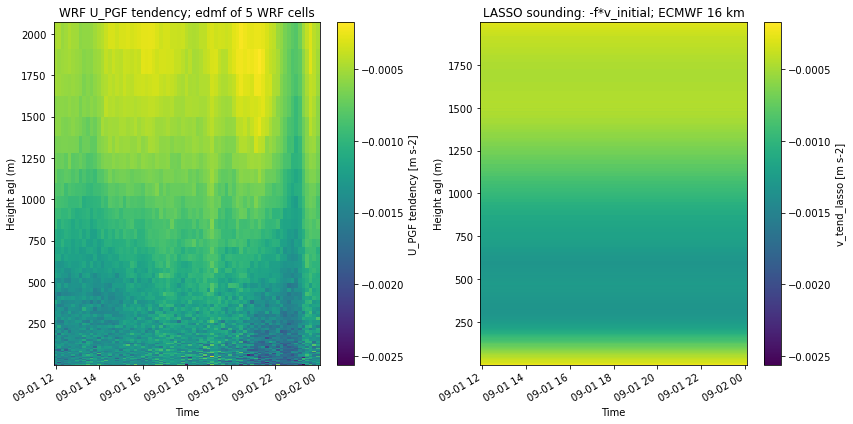

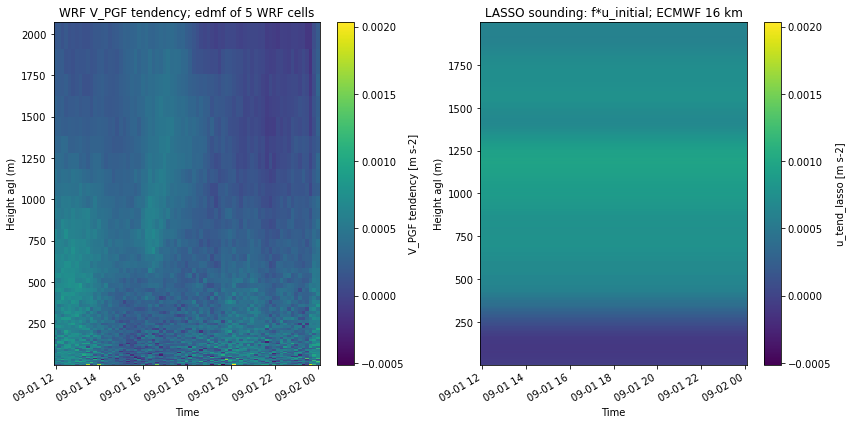

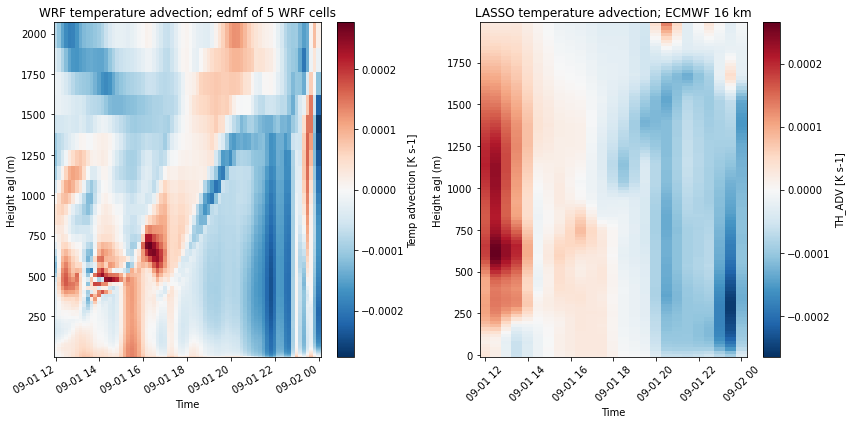

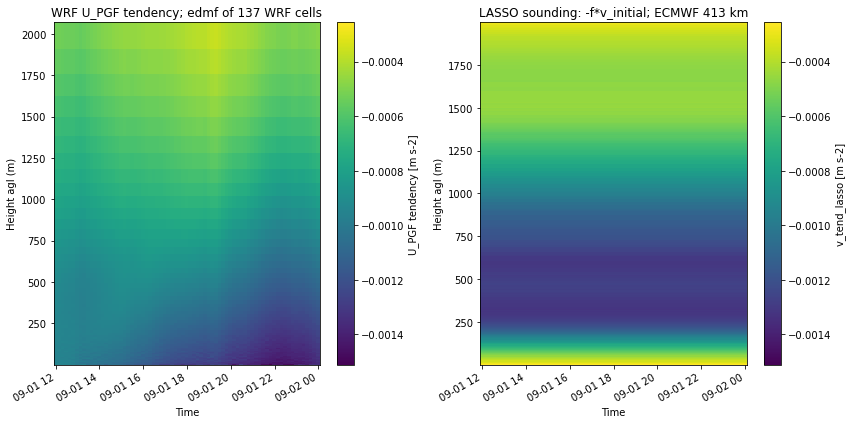

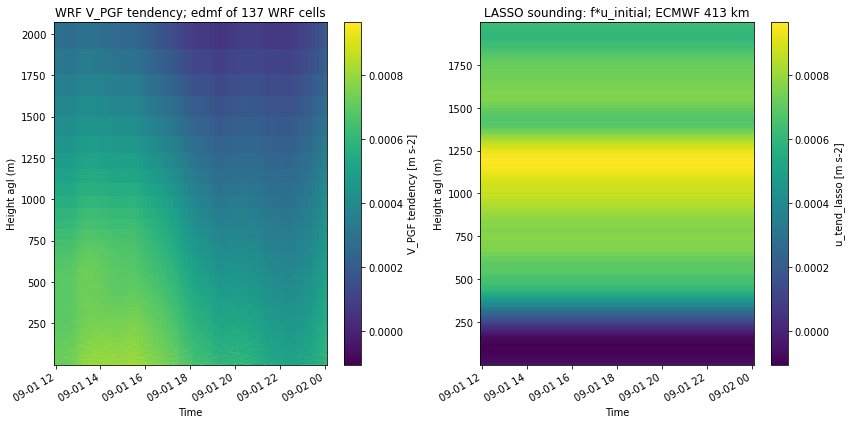

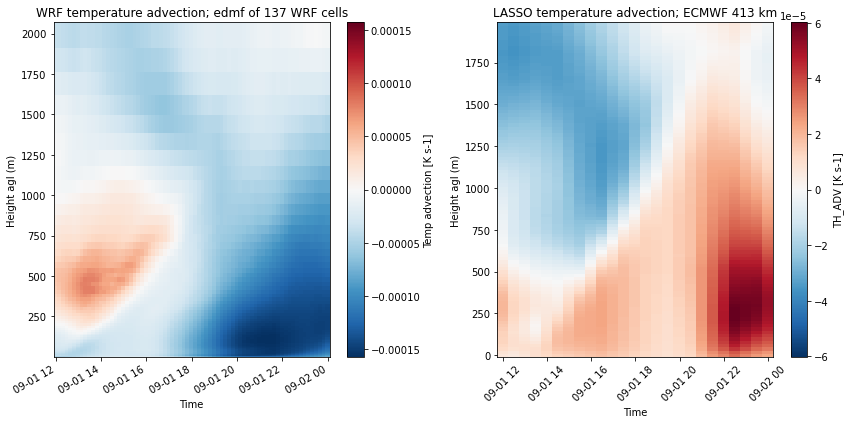

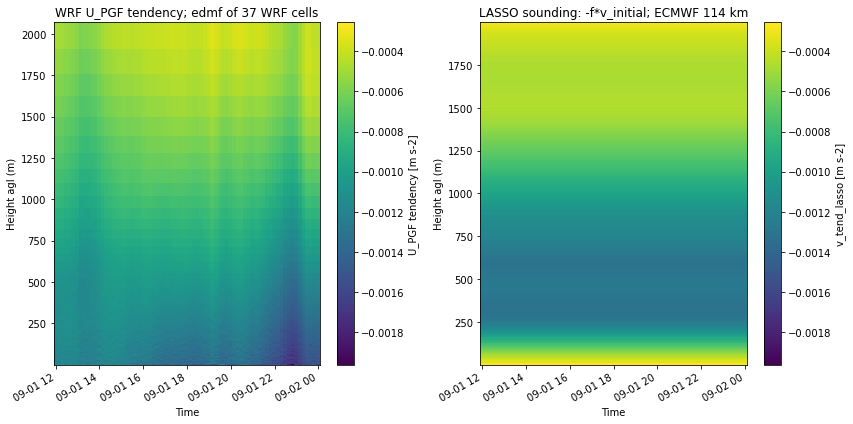

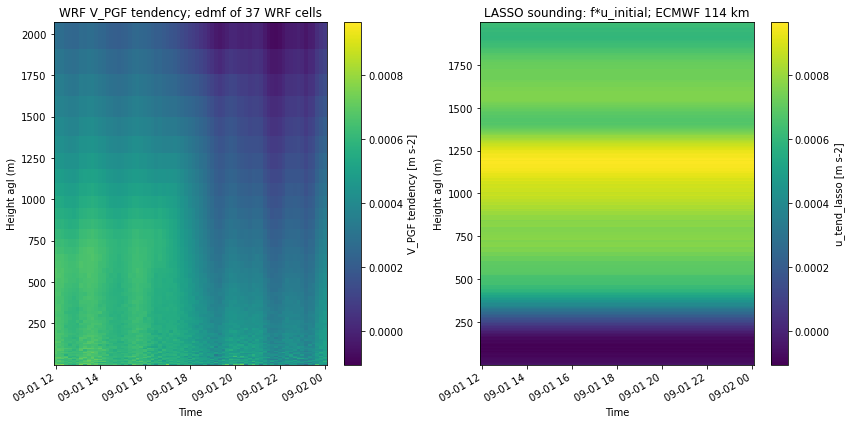

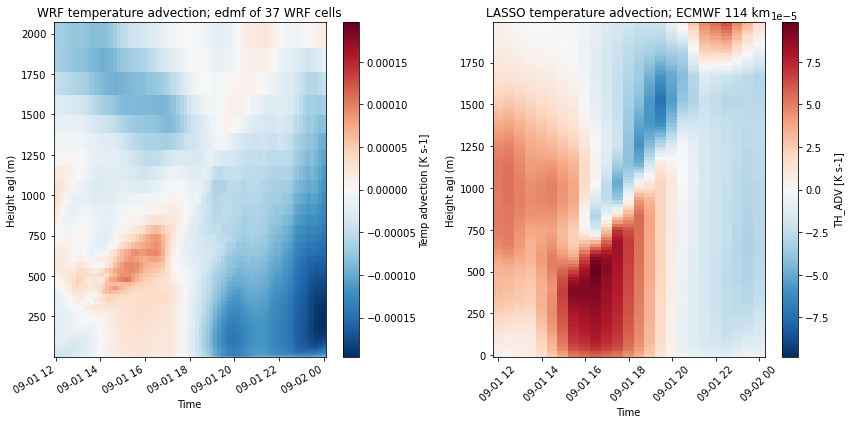

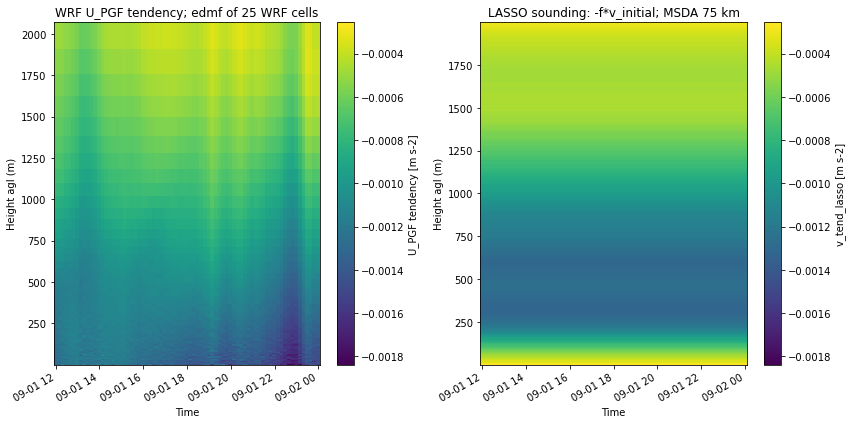

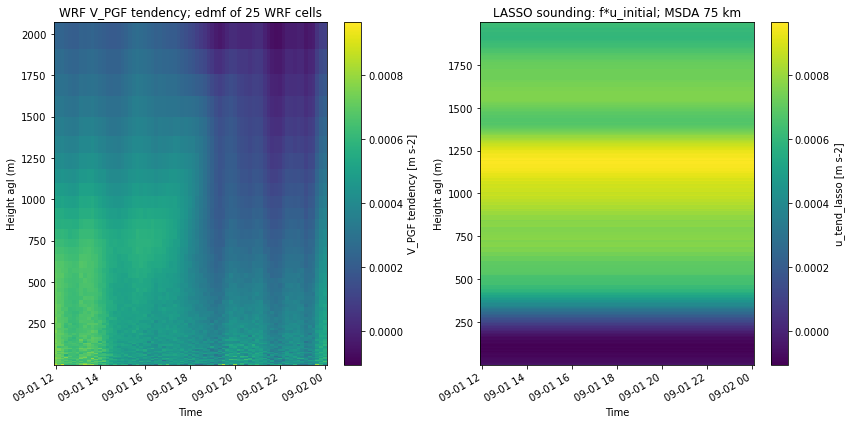

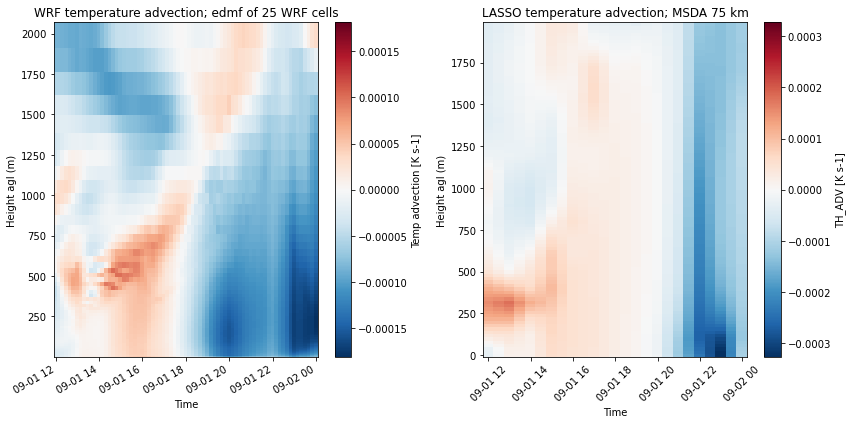

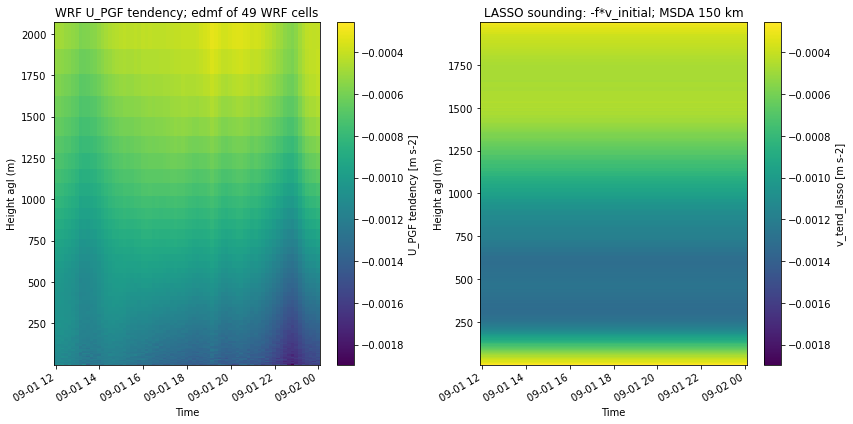

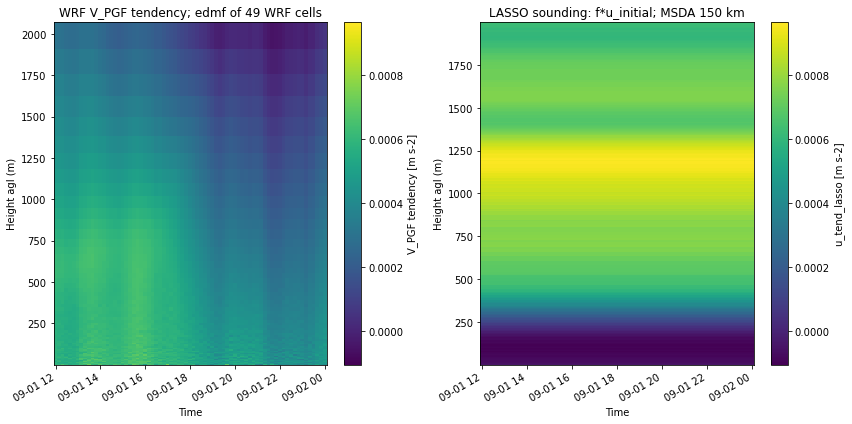

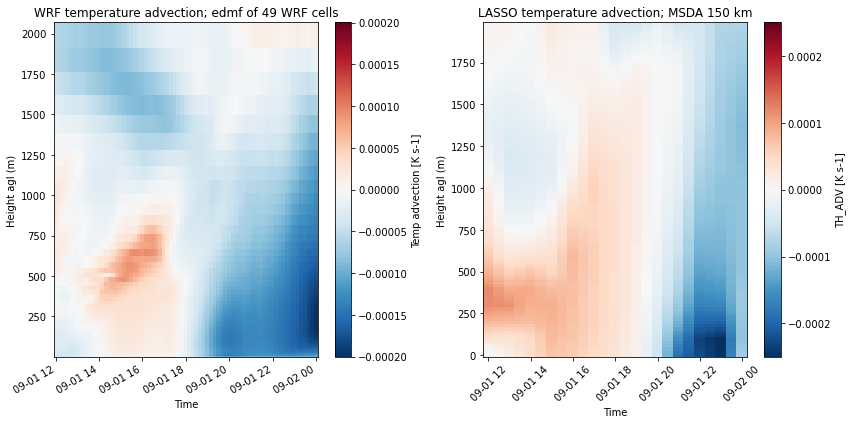

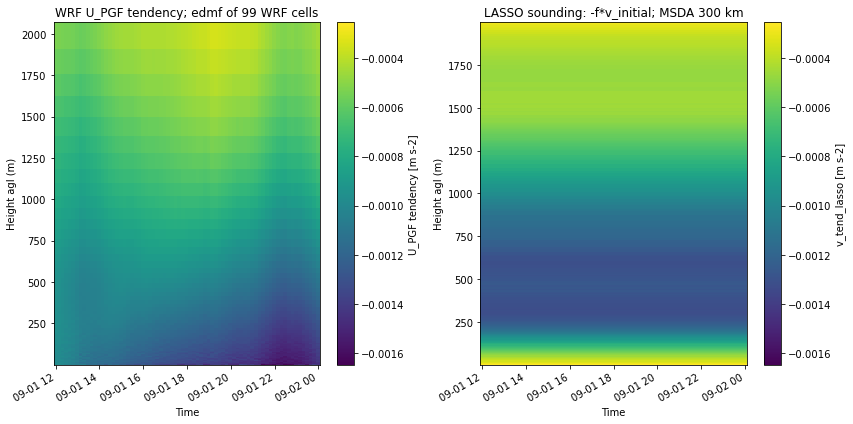

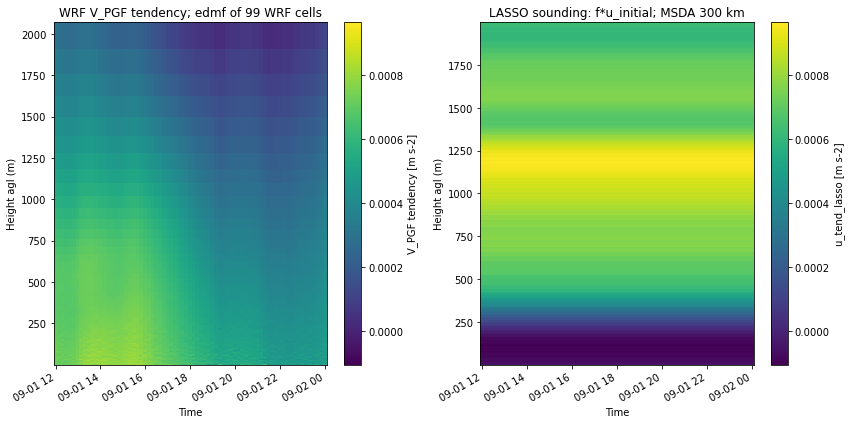

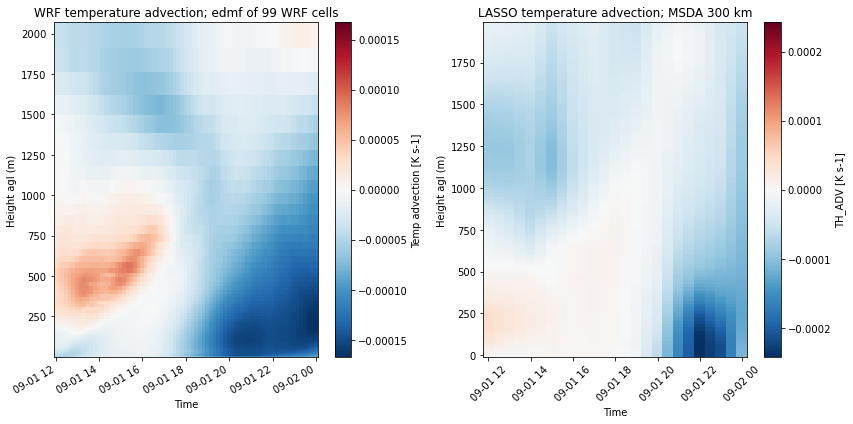

In [2]:
# for each wrf run
for pair in wrf_dirs: 
    
    date = pair[0]
    wrf_setting = pair[1]
    
    if wrf_setting == 'm':
        wrf_txt = 'mynn'
    elif wrf_setting == 'e':
        wrf_txt = 'edmf'

    wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'+date+wrf_setting+'/auxout/target/'

    # horizontal resolutions of wrf dataset, in km
    wrf_hres = 3
    wrf_file_list = glob.glob(wrf_path+'mmc_d02*')

    # for each lasso config
    # not select the first config because the forcing is none
    for ind, row in lasso_metadf[1:].iterrows(): 

        lasso_config = '/projects/mmcpnnl/jlee/lasso/'+date+'/'+date+'-'\
            +str(row['simulation-id'])+'/config/'

        lasso_sounding = lasso_config+'input_sounding'
        lasso_forcing = lasso_config+'input_ls_forcing.nc'

        # horizontal resolutions of lasso dataset, in km
        lasso_hres = row['forcing-scale-km']

        # number of wrf cells in 1 lasso cell, in 1 direction 
        # wrf cell span includes the cell of target location
        wrf_cell_span = np.floor(lasso_hres/wrf_hres)

        # convert an even number to an odd number, round down
        # so the total wrf cell span is smaller than a lasso cell horizontal resolution
        if (wrf_cell_span % 2) == 0:
            wrf_cell_span -= 1

        # wrf cell to account for in each direction
        wrf_ij_diff = (wrf_cell_span-1)/2

        for ind, file in enumerate(wrf_file_list):

            wrf_single = Dataset(file, 'r')

            site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
            area_start_ind = site_loc_ij.values-wrf_ij_diff
            area_end_ind = site_loc_ij.values+wrf_ij_diff

            wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
            # height should not change over time in wrf
            z_agl  = wrf.getvar(wrf_single, 'height_agl')

            ru_tend = wrf.getvar(wrf_single, 'RU_TEND_PGF', timeidx=wrf.ALL_TIMES)
            muu = wrf.getvar(wrf_single, 'MUU', timeidx=wrf.ALL_TIMES)
            # to match lasso data
            u_tend = ru_tend/muu

            rv_tend = wrf.getvar(wrf_single, 'RV_TEND_PGF', timeidx=wrf.ALL_TIMES)
            muv = wrf.getvar(wrf_single, 'MUV', timeidx=wrf.ALL_TIMES)
            v_tend = rv_tend/muv

            t_tend = wrf.getvar(wrf_single, 'T_TEND_ADV', timeidx=wrf.ALL_TIMES)
            mut = wrf.getvar(wrf_single, 'MUT', timeidx=wrf.ALL_TIMES)
            t_tend = t_tend/mut

            hgt = z_agl[:, site_loc_ij.values[1], site_loc_ij.values[0]]

            # j first, i second
            u_slice = u_tend.isel(south_north=slice(int(area_start_ind[1]), int(area_end_ind[1]+1)), 
                                  west_east_stag=slice(int(area_start_ind[0]), int(area_end_ind[0]+1)))
            u_mean = u_slice.mean(dim=['south_north', 'west_east_stag'])

            v_slice = v_tend.isel(south_north_stag=slice(int(area_start_ind[1]), int(area_end_ind[1]+1)), 
                                  west_east=slice(int(area_start_ind[0]), int(area_end_ind[0]+1)))
            v_mean = v_slice.mean(dim=['south_north_stag', 'west_east'])

            t_slice = t_tend.isel(south_north=slice(int(area_start_ind[1]), int(area_end_ind[1]+1)), 
                                  west_east=slice(int(area_start_ind[0]), int(area_end_ind[0]+1)))
            t_mean = t_slice.mean(dim=['south_north', 'west_east'])

            ds = u_mean.to_dataset(name='U_PGF tendency [m s-2]')
            ds['V_PGF tendency [m s-2]'] = v_mean
            ds['Temp advection [K s-1]'] = t_mean

            if ind == 0: 
                ds_all = ds
            else: 
                ds_all = xr.concat([ds, ds_all], dim='Time')

            # assign height coordinates to the last iteration
            if ind == len(wrf_file_list)-1:
                ds_all = ds_all.assign_coords({'Height': ('bottom_top', hgt)})

        ds_all = ds_all.sortby('Time')

        wrf_ds_below2km = ds_all.where(ds_all['Height'] < threshold_height, drop=True)

        # lasso sounding
        lasso_input_sounding_col = ['height agl', 'potential temperature', 'vapor mixing ratio', 
                                'u velocity', 'v velocity']

        df = pd.read_csv(lasso_sounding, skiprows=1, sep=' ')

        new_df = (df.T.reset_index().T.reset_index(drop=True)
                    .set_axis([i for i in lasso_input_sounding_col], axis=1))

        for col in new_df.columns:
            new_df[col] = pd.to_numeric(new_df[col])

        f = 2 * 7.292*1e-5 * math.sin(math.radians(site_latitude))

        new_df['u_tend_lasso'] = f*new_df['u velocity']
        new_df['v_tend_lasso'] = -f*new_df['v velocity']

        lasso_sounding_ds = new_df.to_xarray()
        lasso_sounding_ds = lasso_sounding_ds.rename({'index': 'Height'})
        lasso_sounding_ds['Height'] = lasso_sounding_ds['height agl']
        # refer to WRF ds
        lasso_sounding_ds = lasso_sounding_ds.assign_coords({'Time': ds_all.Time})

        lasso_sounding_ds['u_tend_lasso [m s-2]'], _ = xr.broadcast(lasso_sounding_ds['u_tend_lasso'], 
                                                                    lasso_sounding_ds['Time'])
        lasso_sounding_ds['v_tend_lasso [m s-2]'], _ = xr.broadcast(lasso_sounding_ds['v_tend_lasso'], 
                                                                    lasso_sounding_ds['Time'])
        lasso_sounding_ds_below2km = lasso_sounding_ds.where(lasso_sounding_ds['Height'] < threshold_height, 
                                                             drop=True)

        wrf_run = wrf_txt+' of '+str(round(wrf_cell_span))+' WRF cells'
        lasso_run = row['large-scale-forcing']+' '+str(row['forcing-scale-km'])+' km'
        lasso_str = 'lasso'+str(row['simulation-id'])
        plt_txt = date+wrf_txt+'_'+lasso_str

        plot_timeheight_wrflasso_uvtend('U_PGF tendency [m s-2]', 'v_tend_lasso [m s-2]', 
                                        'WRF U_PGF tendency; '+wrf_run, 
                                        'LASSO sounding: -f*v_initial; '+lasso_run, 
                                        'ugpf_-fv', plt_txt)

        plot_timeheight_wrflasso_uvtend('V_PGF tendency [m s-2]', 'u_tend_lasso [m s-2]', 
                                        'WRF V_PGF tendency; '+wrf_run, 
                                        'LASSO sounding: f*u_initial; '+lasso_run, 
                                        'vgpf_fu', plt_txt)

        # lasso forcing
        if date == '0805':
            month, day = 8, 5
        elif date == '0901':
            month, day = 9, 1
        lasso_forcing_ds = get_lasso_forcing_ds(lasso_forcing, 2018, month, day)

        lasso_forcing_ds_below2km = lasso_forcing_ds.where(lasso_forcing_ds['force_layers'] < threshold_height, 
                                                           drop=True)

        plot_timeheight_wrflasso_tempadv(wrf_ds_below2km, lasso_forcing_ds_below2km, wrf_run, lasso_run, 
                                         plt_txt)